<a href="https://colab.research.google.com/github/Raj10Gupta/A2A--Codes/blob/main/Feature110imagesupdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
import cv2
cv = cv2.xfeatures2d.SIFT_create()


In [3]:
!pip install torchsummary

In [4]:
import numpy as np

import scipy.io
import os
from numpy.linalg import norm,det,inv,svd
from scipy.linalg import rq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage,spatial
from tqdm.notebook import trange,tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets,models,transforms
from  torch.utils.data import Dataset,DataLoader,ConcatDataset
from skimage import io,transform,data
from torchvision import transforms,utils
import  os
import sklearn.svm
import cv2
from os.path import exists
import pandas as pd
import PIL
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm,tqdm_notebook
from functools import partial
from  torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
class Image:
    def __init__(self,img,position):
        self.img = img
        self.position  = position
        
inliner_matchset = []
def features_matching(a,keypointlength,threshold):
    bestmatch = np.empty((keypointlength), dtype=np.int16)
    img1index = np.empty((keypointlength),dtype=np.init16)
    distance = np.empty((keypointlength))
    index =0
    for j in range(0,keypointlength):
        x=a[j]
        listx = x.tolist()
        x.sort()
        minval1=x[0]
        minval2=x[1]
        itemindex1 = listx.index(minval1)
        itemindex2 = listx.index(minval2)
        ratio = minval1/minval2
            
        if ratio < threshold:
            bestmatch[index] = itemindex1
            distance[index] = minval1
            img1index[index] = j
            index = index + 1
    return [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
    
def compute_Hmography(im1_pts,im2_pts):
    num_matches=len(im1_pts)
    num_rows = 2*num_matches
    num_cols = 9
    A_matrix_shape = (num_rows,num_cols)
    A = np.zeros(A_matrix_shape)
    a_index = 0
    for i in range(0,num_matches):
        (a_x,a_y) = im1_pts[i]
        (b_x,b_y) = im2_pts[i]
        row1 = [a_x,a_y,1,0,0,0,-b_x*a_x,-b_x*a_y,-b_x]
        row2 = [0,0,0,a_x,a_y,1,-b_y*a_x,-b_y*a_y,-b_y]
        A[a_index] = row1
    
        A[a_index+1] = row2
        a_index += 2
            
    U,s,Vt = np.linalg.svd(A)
    H = np.eye(3)
    H = Vt[-1].reshape(3,3)
    return H
    
def displayplot(img,title):
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
        
def RANSAC_alg(f1,f2,matches,nRANSAC,RANSACthresh):
    minMatches = 4
    nBest = 0
    best_inliners = []
    H_estimate = np.eye(3,3)
    global inliner_matchset
    inliner_matchset = []
    for iteration in range(nRANSAC):
        matchSimple = random.sample(matches,minMatches)
        im1_pts = np.empty((minMatches,2))
        im2_pts = np.empty((minMatches,2))
        for i in range(0,minMatches):
            m  = matchSimple[i]
            im1_pts[i] = f1[m.queryIdx].pt
            im2_pts[i] = f2[m.trainIdx].pt
                
        H_estimate = compute_Hmography(im1_pts,im2_pts)
        inliners = get_inliners(f1,f2,matches,H_estimate,RANSACthresh)
        if len(inliners) > nBest:
            nBest = len(inliners)
            best_inliners= inliners
                
    print("Number of best inliners", len(best_inliners))
    for i in range(len(best_inliners)):
        inliner_matchset.append(matches[best_inliners[i]])
    im1_pts = np.empty((len(best_inliners),2))
    im2_pts = np.empty((len(best_inliners),2))
    for i in range(0,len(best_inliners)):
        m = inliner_matchset[i]
        im1_pts[i] = f1[m.queryIdx].pt
        im2_pts[i] = f2[m.trainIdx].pt
    M = compute_Hmography(im1_pts,im2_pts)
    return M, len(best_inliners)
    

    

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raj10gupta","key":"da9c6c2bb369bf5c5c20cf514b90753b"}'}

In [7]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d raj10gupta/uni-campus-dataset

100% 4.34G/4.34G [01:25<00:00, 45.0MB/s]
100% 4.34G/4.34G [01:25<00:00, 54.6MB/s]


In [9]:
from zipfile import ZipFile
file_name = 'uni-campus-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
files_all = os.listdir('/content/RGB-img/img/')
files_all.sort()

folder_path = '/content/RGB-img/img/'
left_files_path_rev = []
right_files_path = []
for file in files_all[:51]:
    left_files_path_rev.append(folder_path + file)
    
    
left_files_path = left_files_path_rev[::-1]


for file in files_all[51:110]:
    right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
images_left_bgr = []
images_right_bgr = []
images_left = []
images_right = []


for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_right_bgr.append(right_img)


100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


In [8]:
images_left_bgr_no_enhance = []

images_right_bgr_no_enhance = []

for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left_bgr_no_enhance.append(left_img)

for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right_bgr_no_enhance.append(right_img)

100%|██████████| 59/59 [00:21<00:00,  2.72it/s]


In [9]:
tqdm = partial(tqdm, position=0, leave=True)


In [ ]:
orb = cv2.ORB_create(5000)
keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for imgs in tqdm(images_left_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_left_orb.append(kpt)
    descriptors_all_left_orb.append(descrip)
    points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_right_orb.append(kpt)
    descriptors_all_right_orb.append(descrip)
    points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:09<00:00,  6.07it/s]


In [11]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

fatal: destination path 'SuperPointPretrainedNetwork' already exists and is not an empty directory.


In [12]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'
cuda = 'True'

In [13]:
def to_kpts(pts,size=1):
    return [cv2.KeyPoint(pt[0],pt[1],size) for pt in pts]

In [14]:
torch.cuda.empty_cache()
class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1,c2,c3,c4,c5,d1 = 64,64,128,128,256,256
        self.conv1a = nn.Conv2d(1,c1,kernel_size=3,stride=1,padding=1)
        self.conv1b = nn.Conv2d(c1,c1,kernel_size=3,stride=1,padding=1)
        self.conv2a = nn.Conv2d(c1,c2,kernel_size=3,stride=1,padding=1)
        self.conv2b = nn.Conv2d(c2,c2,kernel_size=3,stride=1,padding=1)
        self.conv3a = nn.Conv2d(c2,c3,kernel_size=3,stride=1,padding=1)
        self.conv3b = nn.Conv2d(c3,c3,kernel_size=3,stride=1,padding=1)
        self.conv4a = nn.Conv2d(c3,c4,kernel_size=3,stride=1,padding=1)
        self.conv4b = nn.Conv2d(c4,c4,kernel_size=3,stride=1,padding=1)
        self.convPa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        self.convPb = nn.Conv2d(c5,65,kernel_size=1,stride=1,padding=0)
        self.convDa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        
        
        self.convDb = nn.Conv2d(c5,d1,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x  = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc,p=2,dim=1)
        desc = desc.div(torch.unsqueeze(dn,1))
        return semi,desc
    
    
class SuperPointFrontend(object):
    def __init__(self,weights_path,nms_dist,conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh
        self.cell = 8
        self.border_remove = 4
        
        self.net = SuperPointNet()
        if cuda:
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
            self.net.load_state_dict(torch.load(weights_path,map_location=lambda storage, loc: storage))
        self.net.eval()
        
    def nms_fast(self,in_corners,H,W,dist_thresh):
        grid = np.zeros((H,W)).astype(int)
        inds = np.zeros((H,W)).astype(int)
        inds1 = np.argsort(-in_corners[2,:])
        corners  = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int)
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out =  np.vstack((rcorners,in_corners[2])).reshape(3,1)
            return out,np.zeros((1)).astype(int)
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i],rcorners[0,i]] =1
            inds[rcorners[1,i],rcorners[0,i]] =i
        pad = dist_thresh
        grid = np.pad(grid,((pad,pad),(pad,pad)),mode='constant')
        count = 0
        for i,rc  in enumerate(rcorners.T):
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1:
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1]=0
                
                
                grid[pt[1], pt[0]] = -1
                count += 1
                
        keepy, keepx = np.where(grid==-1)
        keepy,keepx = keepy-pad , keepx-pad
        inds_keep = inds[keepy, keepx]
        out  = corners[:,inds_keep]
        values = out[-1,:]
        inds2 = np.argsort(-values)
        out = out[:,inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds
    
    def run(self,img):
        assert img.ndim == 2
        assert img.dtype == np.float32
        H,W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1,H,W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1,1,H,W)
        if self.cuda:
            inp = inp.cuda()
        outs = self.net.forward(inp)
        semi,coarse_desc = outs[0],outs[1]
        semi = semi.data.cpu().numpy().squeeze()
        
        
        dense = np.exp(semi)
        dense = dense / (np.sum(dense,axis=0)+.00001)
        nodust = dense[:-1,:,:]
        Hc = int(H / self.cell)
        Wc = int(W  / self.cell)
        nodust = np.transpose(nodust,[1,2,0])
        heatmap = np.reshape(nodust,[Hc,Wc,self.cell,self.cell])
        heatmap = np.transpose(heatmap,[0,2,1,3])
        heatmap = np.reshape(heatmap,[Hc*self.cell, Wc*self.cell])
        prob_map  = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap,coarse_desc
    
    def key_pt_sampling(self,img,heat_map,coarse_desc,sampled):
        H,W = img.shape[0], img.shape[1]
        xs,ys = np.where(heat_map >= self.conf_thresh)
        if len(xs) == 0:
            return np.zeros((3,0)),None,None
        print("Number of pts selected:",len(xs))
        
        pts = np.zeros((3,len(xs)))
        pts[0,:] = ys
        pts[1,:] = xs
        pts[2,:] = heat_map[xs,ys]
        pts,_ = self.nms_fast(pts,H,W,dist_thresh=self.nms_dist)
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]]
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0,:] < bord, pts[0,:] >= (W-bord))
        toremoveH = np.logical_or(pts[1,:] < bord, pts[0,:] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:,~toremove]
        pts = pts[:,0:sampled]
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D,0))
        else:
            samp_pts = torch.from_numpy(pts[:2,:].copy())
            samp_pts[0,:] = (samp_pts[0,:] / (float(W)/2.))-1.
            samp_pts[1,:] = (samp_pts[1,:] / (float(W)/2.))-1.
            samp_pts = samp_pts.transpose(0,1).contiguous()
            samp_pts = samp_pts.view(1,1,-1,2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D,-1)
            desc /= np.linalg.norm(desc,axis=0)[np.newaxis,:]
        return pts,desc
            
                             
            
                                  
                       

In [15]:
print('Load pre trained network')
fe = SuperPointFrontend(weights_path = weights_path, nms_dist = 4, conf_thresh  = 0.015, nn_thresh=0.7,
                       cuda = cuda)
print('Successfully  loaded pretrained network')

Load pre trained network
Successfully  loaded pretrained network


In [ ]:
num_kps_orb = []
for j  in tqdm(keypoints_all_left_orb + keypoints_all_right_orb):
    num_kps_orb.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 101512.31it/s]


In [18]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)
    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,matched_pts2,cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [19]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    lff1 = np.float32(descripts[0])
    lff = np.float32(descripts[1])
    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe’s ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            
            matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio",len(matches_4))
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matche_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matche_idx])
    
    '''
    # Estimate homography 1
    #Compute H1
    # Estimate homography 1
    #Compute H1
    imm1_pts=np.empty((len(matches_4),2))
    imm2_pts=np.empty((len(matches_4),2))
    for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)
    H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1000, RANSACthresh=6)
    '''
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)

    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches",len(inlier_matchset))
    print("\n")
    '''
    if len(inlier_matchset)<50:
        matches_4 = []
        ratio = 0.67
        # loop over the raw matches
        for m in matches_lf1_lf:
           # ensure the distance is within a certain ratio of each
           # other (i.e. Lowe’s ratio test)
           if len(m) == 2 and m[0].distance < m[1].distance * ratio:
           #matches_1.append((m[0].trainIdx, m[0].queryIdx))
           matches_4.append(m[0])
        print("Number of matches After Lowe's Ratio New",len(matches_4))
        matches_idx = np.array([m.queryIdx for m in matches_4])
        imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
        matches_idx = np.array([m.trainIdx for m in matches_4])
        imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
        Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
        inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
        print("Number of Robust matches New",len(inlier_matchset))
        print("\n")
       '''
    #H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1500, RANSACthresh=6)
    #global inlier_matchset
    if disp==True:
        dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
        displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
    return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

    

In [20]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1])
    H_left_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1])
    H_right_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)    
    

  4%|▍         | 2/51 [00:00<00:08,  5.45it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 253



Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 196




  8%|▊         | 4/51 [00:00<00:08,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 391
Number of Robust matches 254



Number of matches 5000
Number of matches After Lowe's Ratio 465
Number of Robust matches 357




 12%|█▏        | 6/51 [00:01<00:08,  5.48it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 377
Number of Robust matches 263



Number of matches 5000
Number of matches After Lowe's Ratio 507
Number of Robust matches 373




 16%|█▌        | 8/51 [00:01<00:07,  5.57it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 432
Number of Robust matches 282



Number of matches 5000
Number of matches After Lowe's Ratio 472
Number of Robust matches 330




 20%|█▉        | 10/51 [00:01<00:07,  5.60it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 568
Number of Robust matches 382



Number of matches 5000
Number of matches After Lowe's Ratio 436
Number of Robust matches 256




 24%|██▎       | 12/51 [00:02<00:08,  4.84it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 320
Number of Robust matches 163



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 246




 27%|██▋       | 14/51 [00:02<00:07,  5.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 400
Number of Robust matches 214



Number of matches 5000
Number of matches After Lowe's Ratio 337
Number of Robust matches 202




 31%|███▏      | 16/51 [00:03<00:06,  5.29it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 335
Number of Robust matches 186



Number of matches 5000
Number of matches After Lowe's Ratio 345
Number of Robust matches 147




 35%|███▌      | 18/51 [00:03<00:06,  5.32it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 395
Number of Robust matches 216



Number of matches 5000
Number of matches After Lowe's Ratio 329
Number of Robust matches 157




 37%|███▋      | 19/51 [00:03<00:06,  5.30it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 275
Number of Robust matches 96



Number of matches 5000
Number of matches After Lowe's Ratio 293


 39%|███▉      | 20/51 [00:03<00:05,  5.27it/s]

Number of Robust matches 101



Number of matches 5000
Number of matches After Lowe's Ratio 190


 41%|████      | 21/51 [00:04<00:06,  4.96it/s]

Number of Robust matches 45



Number of matches 5000
Number of matches After Lowe's Ratio 153


 45%|████▌     | 23/51 [00:04<00:05,  4.90it/s]

Number of Robust matches 11



Number of matches 5000
Number of matches After Lowe's Ratio 342
Number of Robust matches 144




 49%|████▉     | 25/51 [00:04<00:04,  5.22it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 418
Number of Robust matches 195



Number of matches 5000
Number of matches After Lowe's Ratio 319
Number of Robust matches 139




 51%|█████     | 26/51 [00:04<00:04,  5.23it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 297
Number of Robust matches 129



Number of matches 5000
Number of matches After Lowe's Ratio 273


 53%|█████▎    | 27/51 [00:05<00:04,  5.08it/s]

Number of Robust matches 70



Number of matches 5000
Number of matches After Lowe's Ratio 342


 57%|█████▋    | 29/51 [00:05<00:04,  4.95it/s]

Number of Robust matches 71



Number of matches 5000
Number of matches After Lowe's Ratio 263
Number of Robust matches 68




 61%|██████    | 31/51 [00:05<00:03,  5.26it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 324
Number of Robust matches 177



Number of matches 5000
Number of matches After Lowe's Ratio 402
Number of Robust matches 246




 65%|██████▍   | 33/51 [00:06<00:03,  5.43it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 514
Number of Robust matches 343



Number of matches 5000
Number of matches After Lowe's Ratio 520
Number of Robust matches 374




 69%|██████▊   | 35/51 [00:06<00:02,  5.58it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 497
Number of Robust matches 310



Number of matches 5000
Number of matches After Lowe's Ratio 489
Number of Robust matches 300




 73%|███████▎  | 37/51 [00:07<00:02,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 420
Number of Robust matches 234



Number of matches 5000
Number of matches After Lowe's Ratio 336
Number of Robust matches 162




 76%|███████▋  | 39/51 [00:07<00:02,  5.58it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 307
Number of Robust matches 142



Number of matches 5000
Number of matches After Lowe's Ratio 572
Number of Robust matches 423




 80%|████████  | 41/51 [00:07<00:01,  5.63it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 521
Number of Robust matches 389



Number of matches 5000
Number of matches After Lowe's Ratio 333
Number of Robust matches 202




 84%|████████▍ | 43/51 [00:08<00:01,  5.02it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 340
Number of Robust matches 181



Number of matches 5000
Number of matches After Lowe's Ratio 442
Number of Robust matches 269




 88%|████████▊ | 45/51 [00:08<00:01,  5.32it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 312
Number of Robust matches 181



Number of matches 5000
Number of matches After Lowe's Ratio 368
Number of Robust matches 200




 92%|█████████▏| 47/51 [00:08<00:00,  5.41it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 356
Number of Robust matches 155



Number of matches 5000
Number of matches After Lowe's Ratio 392
Number of Robust matches 156




 94%|█████████▍| 48/51 [00:09<00:00,  5.24it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 318
Number of Robust matches 94



Number of matches 5000
Number of matches After Lowe's Ratio 413


 96%|█████████▌| 49/51 [00:09<00:00,  5.28it/s]

Number of Robust matches 143



Number of matches 5000
Number of matches After Lowe's Ratio 196


  2%|▏         | 1/59 [00:00<00:10,  5.43it/s]

Number of Robust matches 22



Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 233




  5%|▌         | 3/59 [00:00<00:10,  5.55it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 242
Number of Robust matches 97



Number of matches 5000
Number of matches After Lowe's Ratio 353
Number of Robust matches 197




  8%|▊         | 5/59 [00:00<00:09,  5.51it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 379
Number of Robust matches 166



Number of matches 5000
Number of matches After Lowe's Ratio 394
Number of Robust matches 202




 10%|█         | 6/59 [00:01<00:09,  5.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 180



Number of matches 5000
Number of matches After Lowe's Ratio 147


 12%|█▏        | 7/59 [00:01<00:10,  5.16it/s]

Number of Robust matches 6



Number of matches 5000
Number of matches After Lowe's Ratio 206


 14%|█▎        | 8/59 [00:01<00:10,  4.94it/s]

Number of Robust matches 30



Number of matches 5000
Number of matches After Lowe's Ratio 175


 17%|█▋        | 10/59 [00:01<00:09,  4.96it/s]

Number of Robust matches 38



Number of matches 5000
Number of matches After Lowe's Ratio 301
Number of Robust matches 137




 20%|██        | 12/59 [00:02<00:08,  5.29it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 507
Number of Robust matches 331



Number of matches 5000
Number of matches After Lowe's Ratio 501
Number of Robust matches 327




 22%|██▏       | 13/59 [00:02<00:08,  5.36it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 331
Number of Robust matches 194



Number of matches 5000
Number of matches After Lowe's Ratio 221


 25%|██▌       | 15/59 [00:02<00:08,  5.39it/s]

Number of Robust matches 64



Number of matches 5000
Number of matches After Lowe's Ratio 432
Number of Robust matches 300




 29%|██▉       | 17/59 [00:03<00:07,  5.39it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 301
Number of Robust matches 151



Number of matches 5000
Number of matches After Lowe's Ratio 535
Number of Robust matches 386




 32%|███▏      | 19/59 [00:03<00:07,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 630
Number of Robust matches 491



Number of matches 5000
Number of matches After Lowe's Ratio 388
Number of Robust matches 267




 36%|███▌      | 21/59 [00:03<00:06,  5.60it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 497
Number of Robust matches 363



Number of matches 5000
Number of matches After Lowe's Ratio 352
Number of Robust matches 210




 37%|███▋      | 22/59 [00:04<00:06,  5.54it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 495
Number of Robust matches 320




 41%|████      | 24/59 [00:04<00:06,  5.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 429
Number of Robust matches 246



Number of matches 5000
Number of matches After Lowe's Ratio 462
Number of Robust matches 283




 44%|████▍     | 26/59 [00:04<00:06,  5.35it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 403
Number of Robust matches 252



Number of matches 5000
Number of matches After Lowe's Ratio 359
Number of Robust matches 158




 47%|████▋     | 28/59 [00:05<00:05,  5.43it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 396
Number of Robust matches 167



Number of matches 5000
Number of matches After Lowe's Ratio 412
Number of Robust matches 195




 51%|█████     | 30/59 [00:05<00:05,  5.42it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 437
Number of Robust matches 196



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 173




 53%|█████▎    | 31/59 [00:05<00:05,  5.48it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 403
Number of Robust matches 225



Number of matches 5000
Number of matches After Lowe's Ratio 124


 54%|█████▍    | 32/59 [00:06<00:05,  5.18it/s]

Number of Robust matches 7



Number of matches 5000
Number of matches After Lowe's Ratio 215


 56%|█████▌    | 33/59 [00:06<00:05,  4.95it/s]

Number of Robust matches 43



Number of matches 5000
Number of matches After Lowe's Ratio 128


 58%|█████▊    | 34/59 [00:06<00:05,  4.79it/s]

Number of Robust matches 6



Number of matches 5000
Number of matches After Lowe's Ratio 230


 61%|██████    | 36/59 [00:06<00:04,  4.99it/s]

Number of Robust matches 57



Number of matches 5000
Number of matches After Lowe's Ratio 389
Number of Robust matches 210




 64%|██████▍   | 38/59 [00:07<00:04,  5.19it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 404
Number of Robust matches 163



Number of matches 5000
Number of matches After Lowe's Ratio 370
Number of Robust matches 160




 66%|██████▌   | 39/59 [00:07<00:03,  5.19it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 303
Number of Robust matches 94



Number of matches 5000
Number of matches After Lowe's Ratio 301


 69%|██████▉   | 41/59 [00:07<00:03,  5.09it/s]

Number of Robust matches 71



Number of matches 5000
Number of matches After Lowe's Ratio 410
Number of Robust matches 165




 73%|███████▎  | 43/59 [00:08<00:03,  5.26it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 245
Number of Robust matches 75



Number of matches 5000
Number of matches After Lowe's Ratio 376
Number of Robust matches 213




 76%|███████▋  | 45/59 [00:08<00:02,  5.38it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 330
Number of Robust matches 124



Number of matches 5000
Number of matches After Lowe's Ratio 307
Number of Robust matches 136




 80%|███████▉  | 47/59 [00:08<00:02,  5.49it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 298
Number of Robust matches 186



Number of matches 5000
Number of matches After Lowe's Ratio 550
Number of Robust matches 355




 83%|████████▎ | 49/59 [00:09<00:01,  5.50it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 417
Number of Robust matches 287



Number of matches 5000
Number of matches After Lowe's Ratio 662
Number of Robust matches 506




 86%|████████▋ | 51/59 [00:09<00:01,  5.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 459
Number of Robust matches 280



Number of matches 5000
Number of matches After Lowe's Ratio 598
Number of Robust matches 407




 90%|████████▉ | 53/59 [00:10<00:01,  5.49it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 300
Number of Robust matches 172



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 233




 93%|█████████▎| 55/59 [00:10<00:00,  5.05it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 365
Number of Robust matches 219



Number of matches 5000
Number of matches After Lowe's Ratio 597
Number of Robust matches 421




 97%|█████████▋| 57/59 [00:10<00:00,  5.20it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 396
Number of Robust matches 258



Number of matches 5000
Number of matches After Lowe's Ratio 541
Number of Robust matches 371




 98%|█████████▊| 58/59 [00:11<00:00,  5.33it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 469
Number of Robust matches 288




# RAM Crashed here after 110 images for orb

In [22]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht


In [23]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_left):
        if j==  0:
            H_trans = Ht@H
            
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_left[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        if j == 0:
            result[t[1]:h+t[1],t[0]:w+t[0]] = images_left[0]
            warp_img_init_prev = result
            continue
        black_pixels = np.where((warp_img_init_prev[:,:,0]==0)&(warp_img_init_prev[:,:,1]==0)&(warp_img_init_prev[:,:,2]==0))
        warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step31:Done')
    return warp_img_init_prev
    
def final_step_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_right):
        if j==  0:
            H_trans = Ht@H
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_right[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        
        
        black_pixels = np.where((warp_img_prev[:,:,0]==0)&(warp_img_prev[:,:,1]==0)&(warp_img_prev[:,:,2]==0))
        warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step32:Done')
    return warp_img_prev

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_orb,H_right_orb)


NameError: ignored

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)


In [ ]:
warp_imgs_all_orb = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_orb , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-SIFT')

# ROOTSIFT 110 images

In [ ]:
class RootSIFT:
    def __init__(self):
        # initialize the SIFT feature extractor
        #self.extractor = cv2.DescriptorExtractor_create("SIFT")
        self.sift = cv2.xfeatures2d.SIFT_create()
    def compute(self, image, kps, eps=1e-7):
        # compute SIFT descriptors
        (kps, descs) = self.sift.compute(image, kps)
        # if there are no keypoints or descriptors, return an empty tuple
        if len(kps) == 0:
            return ([], None)
        # apply the Hellinger kernel by first L1-normalizing, taking the
        # square-root, and then L2-normalizing
        descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        descs /= (descs.sum(axis=0) + eps)
        descs = np.sqrt(descs)
        #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        # return a tuple of the keypoints and descriptors
        return (kps, descs)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]
 
keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]
 
for imgs in tqdm(images_left_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_left_rootsift.append(kpt)
    descriptors_all_left_rootsift.append(descrip)
    points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
for imgs in tqdm(images_right_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_right_rootsift.append(kpt)
    descriptors_all_right_rootsift.append(descrip)
    points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

NameError: ignored

In [ ]:
num_kps_rootsift = []
for j  in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift):
    num_kps_rootsift.append(len(j))

In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1])
    H_left_rootsift.append(H_a)
    num_matches_rootsift.append(matches)
    num_good_matches_rootsift.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1])
    H_right_rootsift.append(H_a)
    num_matches_rootsift.append(matches)
    num_good_matches_rootsift.append(gd_matches) 

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_rootsift,H_right_rootsift)


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_rootsift = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_rootsift , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-ROOTSIFT')

# For BRISK 110 image

In [ ]:
Threshl=60;
Octaves=8;
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]


keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]


for imgs in tqdm(images_left_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_left_brisk.append(kpt)
    descriptors_all_left_brisk.append(descrip)
    points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_right_brisk.append(kpt)
    descriptors_all_right_brisk.append(descrip)
    points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:49<00:00,  1.20it/s]


In [ ]:
num_kps_brisk = []
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk):
    num_kps_brisk.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 327912.89it/s]


In [ ]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1])
    H_left_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1])
    H_right_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches) 

  2%|▏         | 1/51 [00:02<02:22,  2.85s/it]


Number of matches 32653
Number of matches After Lowe's Ratio 2170
Number of Robust matches 1357




  4%|▍         | 2/51 [00:05<02:23,  2.94s/it]


Number of matches 32146
Number of matches After Lowe's Ratio 2338
Number of Robust matches 1561




  6%|▌         | 3/51 [00:09<02:25,  3.04s/it]


Number of matches 37734
Number of matches After Lowe's Ratio 2467
Number of Robust matches 1622




  8%|▊         | 4/51 [00:13<02:36,  3.33s/it]


Number of matches 37547
Number of matches After Lowe's Ratio 3491
Number of Robust matches 2593




 10%|▉         | 5/51 [00:17<02:39,  3.46s/it]


Number of matches 34839
Number of matches After Lowe's Ratio 2751
Number of Robust matches 2054




 12%|█▏        | 6/51 [00:20<02:34,  3.42s/it]


Number of matches 30911
Number of matches After Lowe's Ratio 2663
Number of Robust matches 2050




 14%|█▎        | 7/51 [00:23<02:26,  3.32s/it]


Number of matches 32047
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1907




 16%|█▌        | 8/51 [00:26<02:21,  3.30s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 2974
Number of Robust matches 2181




 18%|█▊        | 9/51 [00:30<02:19,  3.32s/it]


Number of matches 31280
Number of matches After Lowe's Ratio 3160
Number of Robust matches 2459




 20%|█▉        | 10/51 [00:33<02:13,  3.25s/it]


Number of matches 31427
Number of matches After Lowe's Ratio 2378
Number of Robust matches 1731




 22%|██▏       | 11/51 [00:36<02:08,  3.20s/it]


Number of matches 32135
Number of matches After Lowe's Ratio 1942
Number of Robust matches 1129




 24%|██▎       | 12/51 [00:39<02:05,  3.22s/it]


Number of matches 31815
Number of matches After Lowe's Ratio 2119
Number of Robust matches 1332




 25%|██▌       | 13/51 [00:42<02:01,  3.19s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 2309
Number of Robust matches 1307




 27%|██▋       | 14/51 [00:46<02:00,  3.25s/it]


Number of matches 35870
Number of matches After Lowe's Ratio 1915
Number of Robust matches 1176




 29%|██▉       | 15/51 [00:50<02:07,  3.54s/it]


Number of matches 43958
Number of matches After Lowe's Ratio 2227
Number of Robust matches 879




 31%|███▏      | 16/51 [00:55<02:19,  3.98s/it]


Number of matches 37987
Number of matches After Lowe's Ratio 1862
Number of Robust matches 861




 33%|███▎      | 17/51 [00:59<02:15,  3.99s/it]


Number of matches 32058
Number of matches After Lowe's Ratio 1766
Number of Robust matches 951




 35%|███▌      | 18/51 [01:02<02:02,  3.72s/it]


Number of matches 30297
Number of matches After Lowe's Ratio 1548
Number of Robust matches 577




 37%|███▋      | 19/51 [01:05<01:52,  3.52s/it]


Number of matches 33725
Number of matches After Lowe's Ratio 1002
Number of Robust matches 392




 39%|███▉      | 20/51 [01:08<01:49,  3.53s/it]


Number of matches 34224
Number of matches After Lowe's Ratio 1413
Number of Robust matches 551




 41%|████      | 21/51 [01:12<01:45,  3.50s/it]


Number of matches 34530
Number of matches After Lowe's Ratio 689
Number of Robust matches 246




 43%|████▎     | 22/51 [01:15<01:39,  3.43s/it]


Number of matches 24599
Number of matches After Lowe's Ratio 389
Number of Robust matches 44




 45%|████▌     | 23/51 [01:17<01:26,  3.09s/it]


Number of matches 24704
Number of matches After Lowe's Ratio 1398
Number of Robust matches 666




 47%|████▋     | 24/51 [01:20<01:15,  2.79s/it]


Number of matches 21196
Number of matches After Lowe's Ratio 1365
Number of Robust matches 681




 49%|████▉     | 25/51 [01:21<01:05,  2.54s/it]


Number of matches 26252
Number of matches After Lowe's Ratio 1327
Number of Robust matches 653




 51%|█████     | 26/51 [01:24<01:03,  2.54s/it]


Number of matches 32005
Number of matches After Lowe's Ratio 1718
Number of Robust matches 752




 53%|█████▎    | 27/51 [01:28<01:08,  2.86s/it]


Number of matches 44696
Number of matches After Lowe's Ratio 1773
Number of Robust matches 647




 55%|█████▍    | 28/51 [01:34<01:29,  3.91s/it]


Number of matches 48468
Number of matches After Lowe's Ratio 2358
Number of Robust matches 686




 57%|█████▋    | 29/51 [01:41<01:43,  4.69s/it]


Number of matches 44596
Number of matches After Lowe's Ratio 2135
Number of Robust matches 740




 59%|█████▉    | 30/51 [01:46<01:42,  4.89s/it]


Number of matches 35503
Number of matches After Lowe's Ratio 2129
Number of Robust matches 1063




 61%|██████    | 31/51 [01:50<01:30,  4.55s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 2527
Number of Robust matches 1351




 63%|██████▎   | 32/51 [01:53<01:18,  4.13s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1738




 65%|██████▍   | 33/51 [01:56<01:08,  3.78s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 2757
Number of Robust matches 1782




 67%|██████▋   | 34/51 [01:59<01:02,  3.66s/it]


Number of matches 36828
Number of matches After Lowe's Ratio 2533
Number of Robust matches 1471




 69%|██████▊   | 35/51 [02:03<01:00,  3.80s/it]


Number of matches 39748
Number of matches After Lowe's Ratio 2999
Number of Robust matches 1708




 71%|███████   | 36/51 [02:08<00:59,  3.99s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 3085
Number of Robust matches 1605




 73%|███████▎  | 37/51 [02:12<00:57,  4.08s/it]


Number of matches 39826
Number of matches After Lowe's Ratio 3011
Number of Robust matches 1598




 75%|███████▍  | 38/51 [02:18<01:01,  4.74s/it]


Number of matches 33296
Number of matches After Lowe's Ratio 2040
Number of Robust matches 1265




 76%|███████▋  | 39/51 [02:22<00:52,  4.38s/it]


Number of matches 31758
Number of matches After Lowe's Ratio 3403
Number of Robust matches 2336




 78%|███████▊  | 40/51 [02:25<00:44,  4.04s/it]


Number of matches 31028
Number of matches After Lowe's Ratio 3026
Number of Robust matches 2146




 80%|████████  | 41/51 [02:28<00:36,  3.69s/it]


Number of matches 27881
Number of matches After Lowe's Ratio 1762
Number of Robust matches 1120




 82%|████████▏ | 42/51 [02:31<00:30,  3.37s/it]


Number of matches 27362
Number of matches After Lowe's Ratio 1664
Number of Robust matches 1048




 84%|████████▍ | 43/51 [02:33<00:24,  3.10s/it]


Number of matches 27680
Number of matches After Lowe's Ratio 2330
Number of Robust matches 1713




 86%|████████▋ | 44/51 [02:36<00:20,  2.97s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 2206
Number of Robust matches 1174




 88%|████████▊ | 45/51 [02:39<00:18,  3.05s/it]


Number of matches 27042
Number of matches After Lowe's Ratio 2064
Number of Robust matches 1476




 90%|█████████ | 46/51 [02:41<00:14,  2.90s/it]


Number of matches 29160
Number of matches After Lowe's Ratio 1890
Number of Robust matches 848




 92%|█████████▏| 47/51 [02:44<00:11,  2.88s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 2771
Number of Robust matches 1328




 94%|█████████▍| 48/51 [02:48<00:09,  3.11s/it]


Number of matches 33004
Number of matches After Lowe's Ratio 1826
Number of Robust matches 691




 96%|█████████▌| 49/51 [02:52<00:06,  3.30s/it]


Number of matches 35929
Number of matches After Lowe's Ratio 2738
Number of Robust matches 1059




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 25316
Number of matches After Lowe's Ratio 839
Number of Robust matches 238




  2%|▏         | 1/59 [00:02<02:50,  2.94s/it]


Number of matches 22854
Number of matches After Lowe's Ratio 1641
Number of Robust matches 961




  3%|▎         | 2/59 [00:05<02:36,  2.74s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 1298
Number of Robust matches 570




  5%|▌         | 3/59 [00:08<02:38,  2.83s/it]


Number of matches 26534
Number of matches After Lowe's Ratio 1956
Number of Robust matches 872




  7%|▋         | 4/59 [00:10<02:32,  2.78s/it]


Number of matches 28302
Number of matches After Lowe's Ratio 1863
Number of Robust matches 913




  8%|▊         | 5/59 [00:13<02:27,  2.73s/it]


Number of matches 23435
Number of matches After Lowe's Ratio 1757
Number of Robust matches 1046




 10%|█         | 6/59 [00:15<02:15,  2.55s/it]


Number of matches 26028
Number of matches After Lowe's Ratio 1633
Number of Robust matches 765




 12%|█▏        | 7/59 [00:18<02:13,  2.57s/it]


Number of matches 30921
Number of matches After Lowe's Ratio 534
Number of Robust matches 11




 14%|█▎        | 8/59 [00:21<02:15,  2.66s/it]


Number of matches 25059
Number of matches After Lowe's Ratio 712
Number of Robust matches 240




 15%|█▌        | 9/59 [00:23<02:05,  2.52s/it]


Number of matches 23035
Number of matches After Lowe's Ratio 722
Number of Robust matches 310




 17%|█▋        | 10/59 [00:25<01:55,  2.36s/it]


Number of matches 24778
Number of matches After Lowe's Ratio 904
Number of Robust matches 402




 19%|█▊        | 11/59 [00:28<01:57,  2.46s/it]


Number of matches 35128
Number of matches After Lowe's Ratio 1816
Number of Robust matches 1216




 20%|██        | 12/59 [00:31<02:08,  2.73s/it]


Number of matches 28715
Number of matches After Lowe's Ratio 2213
Number of Robust matches 1584




 22%|██▏       | 13/59 [00:33<02:03,  2.68s/it]


Number of matches 25864
Number of matches After Lowe's Ratio 1205
Number of Robust matches 739




 24%|██▎       | 14/59 [00:36<01:57,  2.60s/it]


Number of matches 24371
Number of matches After Lowe's Ratio 595
Number of Robust matches 253




 25%|██▌       | 15/59 [00:38<01:47,  2.44s/it]


Number of matches 21250
Number of matches After Lowe's Ratio 1599
Number of Robust matches 1084




 27%|██▋       | 16/59 [00:40<01:39,  2.32s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 1103
Number of Robust matches 607




 29%|██▉       | 17/59 [00:43<01:46,  2.54s/it]


Number of matches 31880
Number of matches After Lowe's Ratio 2734
Number of Robust matches 1901




 31%|███       | 18/59 [00:47<01:56,  2.83s/it]


Number of matches 33259
Number of matches After Lowe's Ratio 2985
Number of Robust matches 2417




 32%|███▏      | 19/59 [00:50<01:59,  2.98s/it]


Number of matches 29687
Number of matches After Lowe's Ratio 2424
Number of Robust matches 2032




 34%|███▍      | 20/59 [00:53<02:00,  3.10s/it]


Number of matches 33001
Number of matches After Lowe's Ratio 2445
Number of Robust matches 1709




 36%|███▌      | 21/59 [00:57<02:02,  3.21s/it]


Number of matches 33071
Number of matches After Lowe's Ratio 1853
Number of Robust matches 1322




 37%|███▋      | 22/59 [01:00<02:02,  3.32s/it]


Number of matches 35123
Number of matches After Lowe's Ratio 2208
Number of Robust matches 1511




 39%|███▉      | 23/59 [01:04<02:05,  3.48s/it]


Number of matches 39155
Number of matches After Lowe's Ratio 2279
Number of Robust matches 1444




 41%|████      | 24/59 [01:08<02:09,  3.70s/it]


Number of matches 37668
Number of matches After Lowe's Ratio 2534
Number of Robust matches 1430




 42%|████▏     | 25/59 [01:13<02:17,  4.03s/it]


Number of matches 40615
Number of matches After Lowe's Ratio 2837
Number of Robust matches 1194




 44%|████▍     | 26/59 [01:17<02:15,  4.10s/it]


Number of matches 35723
Number of matches After Lowe's Ratio 2593
Number of Robust matches 1269




 46%|████▌     | 27/59 [01:21<02:05,  3.92s/it]


Number of matches 29133
Number of matches After Lowe's Ratio 1968
Number of Robust matches 908




 47%|████▋     | 28/59 [01:24<01:52,  3.62s/it]


Number of matches 31575
Number of matches After Lowe's Ratio 2590
Number of Robust matches 859




 49%|████▉     | 29/59 [01:27<01:45,  3.52s/it]


Number of matches 30053
Number of matches After Lowe's Ratio 2222
Number of Robust matches 712




 51%|█████     | 30/59 [01:30<01:35,  3.28s/it]


Number of matches 24008
Number of matches After Lowe's Ratio 1563
Number of Robust matches 686




 53%|█████▎    | 31/59 [01:32<01:23,  2.99s/it]


Number of matches 29051
Number of matches After Lowe's Ratio 1383
Number of Robust matches 642




 54%|█████▍    | 32/59 [01:35<01:22,  3.07s/it]


Number of matches 45494
Number of matches After Lowe's Ratio 578
Number of Robust matches 111




 56%|█████▌    | 33/59 [01:41<01:41,  3.92s/it]


Number of matches 41453
Number of matches After Lowe's Ratio 1103
Number of Robust matches 372




 58%|█████▊    | 34/59 [01:47<01:51,  4.47s/it]


Number of matches 47391
Number of matches After Lowe's Ratio 362
Number of Robust matches 5




 59%|█████▉    | 35/59 [01:53<01:55,  4.82s/it]


Number of matches 36711
Number of matches After Lowe's Ratio 1005
Number of Robust matches 319




 61%|██████    | 36/59 [01:57<01:44,  4.54s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 1884
Number of Robust matches 779




 63%|██████▎   | 37/59 [02:00<01:32,  4.19s/it]


Number of matches 32321
Number of matches After Lowe's Ratio 2032
Number of Robust matches 680




 64%|██████▍   | 38/59 [02:03<01:20,  3.83s/it]


Number of matches 28452
Number of matches After Lowe's Ratio 1635
Number of Robust matches 530




 66%|██████▌   | 39/59 [02:06<01:09,  3.48s/it]


Number of matches 26073
Number of matches After Lowe's Ratio 1390
Number of Robust matches 439




 68%|██████▊   | 40/59 [02:08<00:59,  3.13s/it]


Number of matches 27594
Number of matches After Lowe's Ratio 1356
Number of Robust matches 428




 69%|██████▉   | 41/59 [02:11<00:54,  3.01s/it]


Number of matches 29922
Number of matches After Lowe's Ratio 2392
Number of Robust matches 780




 71%|███████   | 42/59 [02:14<00:51,  3.02s/it]


Number of matches 31761
Number of matches After Lowe's Ratio 1460
Number of Robust matches 404




 73%|███████▎  | 43/59 [02:17<00:48,  3.03s/it]


Number of matches 28598
Number of matches After Lowe's Ratio 2069
Number of Robust matches 900




 75%|███████▍  | 44/59 [02:20<00:44,  2.96s/it]


Number of matches 32677
Number of matches After Lowe's Ratio 1941
Number of Robust matches 688




 76%|███████▋  | 45/59 [02:23<00:43,  3.08s/it]


Number of matches 25600
Number of matches After Lowe's Ratio 1482
Number of Robust matches 626




 78%|███████▊  | 46/59 [02:25<00:37,  2.87s/it]


Number of matches 28462
Number of matches After Lowe's Ratio 1087
Number of Robust matches 753




 80%|███████▉  | 47/59 [02:28<00:33,  2.83s/it]


Number of matches 28784
Number of matches After Lowe's Ratio 1396
Number of Robust matches 967




 81%|████████▏ | 48/59 [02:31<00:31,  2.84s/it]


Number of matches 27866
Number of matches After Lowe's Ratio 1431
Number of Robust matches 956




 83%|████████▎ | 49/59 [02:33<00:27,  2.76s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 2258
Number of Robust matches 1588




 85%|████████▍ | 50/59 [02:36<00:23,  2.62s/it]


Number of matches 25632
Number of matches After Lowe's Ratio 1239
Number of Robust matches 697




 86%|████████▋ | 51/59 [02:38<00:20,  2.53s/it]


Number of matches 25983
Number of matches After Lowe's Ratio 2242
Number of Robust matches 1450




 88%|████████▊ | 52/59 [02:40<00:16,  2.38s/it]


Number of matches 13694
Number of matches After Lowe's Ratio 736
Number of Robust matches 422




 90%|████████▉ | 53/59 [02:41<00:11,  1.97s/it]


Number of matches 9250
Number of matches After Lowe's Ratio 1004
Number of Robust matches 578




 92%|█████████▏| 54/59 [02:42<00:07,  1.58s/it]


Number of matches 10843
Number of matches After Lowe's Ratio 598
Number of Robust matches 357




 93%|█████████▎| 55/59 [02:43<00:05,  1.33s/it]


Number of matches 12481
Number of matches After Lowe's Ratio 1368
Number of Robust matches 889




 95%|█████████▍| 56/59 [02:44<00:03,  1.23s/it]


Number of matches 22262
Number of matches After Lowe's Ratio 1268
Number of Robust matches 760




 97%|█████████▋| 57/59 [02:46<00:02,  1.47s/it]


Number of matches 25793
Number of matches After Lowe's Ratio 1895
Number of Robust matches 1288




 98%|█████████▊| 58/59 [02:48<00:01,  1.79s/it]


Number of matches 25355
Number of matches After Lowe's Ratio 2014
Number of Robust matches 1211




In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brisk,H_right_brisk)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_brisk = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-BRISK')

# For Surf 110 images

In [ ]:
surf = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]
for imgs in tqdm(images_left_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_left_surf.append(kpt)
    descriptors_all_left_surf.append(descrip)
    points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_right_surf.append(kpt)
    descriptors_all_right_surf.append(descrip)
    points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [07:35<00:00,  7.72s/it]


In [ ]:
num_kps_surf = []
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf):
    num_kps_surf.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 220015.95it/s]


In [ ]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j++2][::-1],descriptors_all_left_surf[j:j+2][::-1])
    H_left_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1])
    H_right_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)    

  2%|▏         | 1/51 [00:03<02:51,  3.42s/it]


Number of matches 34564
Number of matches After Lowe's Ratio 4305
Number of Robust matches 2365




  4%|▍         | 2/51 [00:06<02:47,  3.42s/it]


Number of matches 34700
Number of matches After Lowe's Ratio 3942
Number of Robust matches 2105




  6%|▌         | 3/51 [00:10<02:51,  3.58s/it]


Number of matches 37406
Number of matches After Lowe's Ratio 4528
Number of Robust matches 2272




  8%|▊         | 4/51 [00:14<02:53,  3.69s/it]


Number of matches 38907
Number of matches After Lowe's Ratio 6807
Number of Robust matches 4559




 10%|▉         | 5/51 [00:18<02:56,  3.85s/it]


Number of matches 37650
Number of matches After Lowe's Ratio 6076
Number of Robust matches 3714




 12%|█▏        | 6/51 [00:22<02:54,  3.87s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 5952
Number of Robust matches 3824




 14%|█▎        | 7/51 [00:27<02:54,  3.95s/it]


Number of matches 38270
Number of matches After Lowe's Ratio 6071
Number of Robust matches 4053




 16%|█▌        | 8/51 [00:31<02:51,  3.98s/it]


Number of matches 38222
Number of matches After Lowe's Ratio 6868
Number of Robust matches 4666




 18%|█▊        | 9/51 [00:35<02:49,  4.03s/it]


Number of matches 37766
Number of matches After Lowe's Ratio 7482
Number of Robust matches 5123




 20%|█▉        | 10/51 [00:39<02:44,  4.01s/it]


Number of matches 38678
Number of matches After Lowe's Ratio 6077
Number of Robust matches 3810




 22%|██▏       | 11/51 [00:43<02:41,  4.05s/it]


Number of matches 38137
Number of matches After Lowe's Ratio 4761
Number of Robust matches 2887




 24%|██▎       | 12/51 [00:47<02:35,  3.98s/it]


Number of matches 37525
Number of matches After Lowe's Ratio 5494
Number of Robust matches 3266




 25%|██▌       | 13/51 [00:51<02:30,  3.96s/it]


Number of matches 37759
Number of matches After Lowe's Ratio 4505
Number of Robust matches 2426




 27%|██▋       | 14/51 [00:55<02:26,  3.96s/it]


Number of matches 38066
Number of matches After Lowe's Ratio 4905
Number of Robust matches 2895




 29%|██▉       | 15/51 [00:59<02:24,  4.02s/it]


Number of matches 38808
Number of matches After Lowe's Ratio 2611
Number of Robust matches 970




 31%|███▏      | 16/51 [01:03<02:19,  4.00s/it]


Number of matches 37519
Number of matches After Lowe's Ratio 3045
Number of Robust matches 1237




 33%|███▎      | 17/51 [01:06<02:13,  3.92s/it]


Number of matches 35706
Number of matches After Lowe's Ratio 3938
Number of Robust matches 1816




 35%|███▌      | 18/51 [01:10<02:10,  3.96s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 3282
Number of Robust matches 1162




 37%|███▋      | 19/51 [01:14<02:07,  3.98s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 2088
Number of Robust matches 694




 39%|███▉      | 20/51 [01:18<02:02,  3.95s/it]


Number of matches 37306
Number of matches After Lowe's Ratio 3300
Number of Robust matches 1358




 41%|████      | 21/51 [01:22<01:58,  3.93s/it]


Number of matches 35977
Number of matches After Lowe's Ratio 1965
Number of Robust matches 661




 43%|████▎     | 22/51 [01:26<01:51,  3.86s/it]


Number of matches 35736
Number of matches After Lowe's Ratio 1506
Number of Robust matches 256




 45%|████▌     | 23/51 [01:30<01:47,  3.83s/it]


Number of matches 36312
Number of matches After Lowe's Ratio 4398
Number of Robust matches 2430




 47%|████▋     | 24/51 [01:33<01:42,  3.78s/it]


Number of matches 35698
Number of matches After Lowe's Ratio 4733
Number of Robust matches 2775




 49%|████▉     | 25/51 [01:37<01:38,  3.78s/it]


Number of matches 36283
Number of matches After Lowe's Ratio 4363
Number of Robust matches 2524




 51%|█████     | 26/51 [01:41<01:34,  3.78s/it]


Number of matches 37204
Number of matches After Lowe's Ratio 4886
Number of Robust matches 2603




 53%|█████▎    | 27/51 [01:45<01:34,  3.92s/it]


Number of matches 38737
Number of matches After Lowe's Ratio 4205
Number of Robust matches 2002




 55%|█████▍    | 28/51 [01:49<01:32,  4.00s/it]


Number of matches 40144
Number of matches After Lowe's Ratio 4512
Number of Robust matches 1567




 57%|█████▋    | 29/51 [01:54<01:30,  4.12s/it]


Number of matches 39400
Number of matches After Lowe's Ratio 4116
Number of Robust matches 1725




 59%|█████▉    | 30/51 [01:58<01:27,  4.15s/it]


Number of matches 38368
Number of matches After Lowe's Ratio 5089
Number of Robust matches 2513




 61%|██████    | 31/51 [02:02<01:23,  4.18s/it]


Number of matches 38791
Number of matches After Lowe's Ratio 5948
Number of Robust matches 2992




 63%|██████▎   | 32/51 [02:06<01:18,  4.15s/it]


Number of matches 38100
Number of matches After Lowe's Ratio 6010
Number of Robust matches 3725




 65%|██████▍   | 33/51 [02:10<01:14,  4.15s/it]


Number of matches 39195
Number of matches After Lowe's Ratio 6882
Number of Robust matches 4280




 67%|██████▋   | 34/51 [02:15<01:10,  4.16s/it]


Number of matches 40180
Number of matches After Lowe's Ratio 6296
Number of Robust matches 3925




 69%|██████▊   | 35/51 [02:19<01:07,  4.21s/it]


Number of matches 40454
Number of matches After Lowe's Ratio 6637
Number of Robust matches 3764




 71%|███████   | 36/51 [02:23<01:03,  4.20s/it]


Number of matches 39823
Number of matches After Lowe's Ratio 6867
Number of Robust matches 4144




 73%|███████▎  | 37/51 [02:27<00:59,  4.23s/it]


Number of matches 39851
Number of matches After Lowe's Ratio 6522
Number of Robust matches 4005




 75%|███████▍  | 38/51 [02:31<00:54,  4.16s/it]


Number of matches 37448
Number of matches After Lowe's Ratio 4818
Number of Robust matches 2622




 76%|███████▋  | 39/51 [02:35<00:48,  4.07s/it]


Number of matches 36805
Number of matches After Lowe's Ratio 8235
Number of Robust matches 5143




 78%|███████▊  | 40/51 [02:39<00:44,  4.04s/it]


Number of matches 39522
Number of matches After Lowe's Ratio 7844
Number of Robust matches 5155




 80%|████████  | 41/51 [02:43<00:40,  4.08s/it]


Number of matches 38125
Number of matches After Lowe's Ratio 5500
Number of Robust matches 2727




 82%|████████▏ | 42/51 [02:47<00:36,  4.01s/it]


Number of matches 37529
Number of matches After Lowe's Ratio 5607
Number of Robust matches 3291




 84%|████████▍ | 43/51 [02:51<00:32,  4.03s/it]


Number of matches 38691
Number of matches After Lowe's Ratio 6988
Number of Robust matches 4096




 86%|████████▋ | 44/51 [02:55<00:27,  4.00s/it]


Number of matches 35997
Number of matches After Lowe's Ratio 4511
Number of Robust matches 2263




 88%|████████▊ | 45/51 [02:59<00:23,  3.95s/it]


Number of matches 35242
Number of matches After Lowe's Ratio 4515
Number of Robust matches 2359




 90%|█████████ | 46/51 [03:03<00:19,  3.84s/it]


Number of matches 36041
Number of matches After Lowe's Ratio 4754
Number of Robust matches 2309




 92%|█████████▏| 47/51 [03:07<00:15,  3.84s/it]


Number of matches 37450
Number of matches After Lowe's Ratio 5994
Number of Robust matches 2647




 94%|█████████▍| 48/51 [03:11<00:11,  3.89s/it]


Number of matches 38454
Number of matches After Lowe's Ratio 3737
Number of Robust matches 1405




 96%|█████████▌| 49/51 [03:15<00:07,  3.98s/it]


Number of matches 38388
Number of matches After Lowe's Ratio 5342
Number of Robust matches 2143




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 38521
Number of matches After Lowe's Ratio 2315
Number of Robust matches 558




  2%|▏         | 1/59 [00:03<03:47,  3.93s/it]


Number of matches 36010
Number of matches After Lowe's Ratio 3959
Number of Robust matches 1974




  3%|▎         | 2/59 [00:08<03:47,  3.99s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 3437
Number of Robust matches 1536




  5%|▌         | 3/59 [00:12<03:46,  4.05s/it]


Number of matches 38139
Number of matches After Lowe's Ratio 4059
Number of Robust matches 2122




  7%|▋         | 4/59 [00:16<03:46,  4.13s/it]


Number of matches 39256
Number of matches After Lowe's Ratio 4416
Number of Robust matches 1974




  8%|▊         | 5/59 [00:20<03:46,  4.20s/it]


Number of matches 42974
Number of matches After Lowe's Ratio 4294
Number of Robust matches 1917




 10%|█         | 6/59 [00:25<03:48,  4.31s/it]


Number of matches 39642
Number of matches After Lowe's Ratio 5068
Number of Robust matches 2280




 12%|█▏        | 7/59 [00:29<03:44,  4.33s/it]


Number of matches 41128
Number of matches After Lowe's Ratio 1279
Number of Robust matches 62




 14%|█▎        | 8/59 [00:34<03:42,  4.37s/it]


Number of matches 41423
Number of matches After Lowe's Ratio 2256
Number of Robust matches 578




 15%|█▌        | 9/59 [00:38<03:39,  4.39s/it]


Number of matches 42807
Number of matches After Lowe's Ratio 3007
Number of Robust matches 1217




 17%|█▋        | 10/59 [00:43<03:38,  4.45s/it]


Number of matches 39765
Number of matches After Lowe's Ratio 3521
Number of Robust matches 1642




 19%|█▊        | 11/59 [00:47<03:30,  4.38s/it]


Number of matches 40727
Number of matches After Lowe's Ratio 4898
Number of Robust matches 3072




 20%|██        | 12/59 [00:51<03:23,  4.32s/it]


Number of matches 35726
Number of matches After Lowe's Ratio 5002
Number of Robust matches 2687




 22%|██▏       | 13/59 [00:55<03:05,  4.03s/it]


Number of matches 29685
Number of matches After Lowe's Ratio 2599
Number of Robust matches 1080




 24%|██▎       | 14/59 [00:58<02:46,  3.71s/it]


Number of matches 32721
Number of matches After Lowe's Ratio 2058
Number of Robust matches 785




 25%|██▌       | 15/59 [01:01<02:37,  3.59s/it]


Number of matches 29698
Number of matches After Lowe's Ratio 4404
Number of Robust matches 2883




 27%|██▋       | 16/59 [01:04<02:28,  3.45s/it]


Number of matches 39479
Number of matches After Lowe's Ratio 3663
Number of Robust matches 1751




 29%|██▉       | 17/59 [01:08<02:33,  3.66s/it]


Number of matches 37048
Number of matches After Lowe's Ratio 6342
Number of Robust matches 3696




 31%|███       | 18/59 [01:12<02:34,  3.76s/it]


Number of matches 39520
Number of matches After Lowe's Ratio 7069
Number of Robust matches 5244




 32%|███▏      | 19/59 [01:16<02:35,  3.88s/it]


Number of matches 36055
Number of matches After Lowe's Ratio 5823
Number of Robust matches 3951




 34%|███▍      | 20/59 [01:20<02:29,  3.84s/it]


Number of matches 36244
Number of matches After Lowe's Ratio 6158
Number of Robust matches 4584




 36%|███▌      | 21/59 [01:24<02:25,  3.83s/it]


Number of matches 35202
Number of matches After Lowe's Ratio 4064
Number of Robust matches 2576




 37%|███▋      | 22/59 [01:28<02:20,  3.80s/it]


Number of matches 37479
Number of matches After Lowe's Ratio 4890
Number of Robust matches 3416




 39%|███▉      | 23/59 [01:32<02:18,  3.86s/it]


Number of matches 36769
Number of matches After Lowe's Ratio 4567
Number of Robust matches 2282




 41%|████      | 24/59 [01:35<02:14,  3.84s/it]


Number of matches 37985
Number of matches After Lowe's Ratio 4618
Number of Robust matches 2230




 42%|████▏     | 25/59 [01:39<02:11,  3.87s/it]


Number of matches 36813
Number of matches After Lowe's Ratio 4421
Number of Robust matches 1926




 44%|████▍     | 26/59 [01:43<02:09,  3.91s/it]


Number of matches 37749
Number of matches After Lowe's Ratio 5481
Number of Robust matches 2884




 46%|████▌     | 27/59 [01:48<02:07,  3.99s/it]


Number of matches 39377
Number of matches After Lowe's Ratio 5147
Number of Robust matches 2125




 47%|████▋     | 28/59 [01:52<02:07,  4.11s/it]


Number of matches 38479
Number of matches After Lowe's Ratio 6090
Number of Robust matches 2625




 49%|████▉     | 29/59 [01:56<02:02,  4.07s/it]


Number of matches 35539
Number of matches After Lowe's Ratio 5383
Number of Robust matches 2066




 51%|█████     | 30/59 [02:00<01:56,  4.02s/it]


Number of matches 37695
Number of matches After Lowe's Ratio 4506
Number of Robust matches 1609




 53%|█████▎    | 31/59 [02:04<01:51,  3.98s/it]


Number of matches 36113
Number of matches After Lowe's Ratio 3576
Number of Robust matches 1523




 54%|█████▍    | 32/59 [02:08<01:50,  4.09s/it]


Number of matches 40129
Number of matches After Lowe's Ratio 1612
Number of Robust matches 405




 56%|█████▌    | 33/59 [02:12<01:48,  4.18s/it]


Number of matches 40100
Number of matches After Lowe's Ratio 2465
Number of Robust matches 859




 58%|█████▊    | 34/59 [02:17<01:48,  4.32s/it]


Number of matches 40735
Number of matches After Lowe's Ratio 855
Number of Robust matches 9




 59%|█████▉    | 35/59 [02:21<01:44,  4.34s/it]


Number of matches 38881
Number of matches After Lowe's Ratio 2720
Number of Robust matches 857




 61%|██████    | 36/59 [02:26<01:37,  4.25s/it]


Number of matches 37388
Number of matches After Lowe's Ratio 3947
Number of Robust matches 1562




 63%|██████▎   | 37/59 [02:29<01:31,  4.15s/it]


Number of matches 35528
Number of matches After Lowe's Ratio 4457
Number of Robust matches 1575




 64%|██████▍   | 38/59 [02:33<01:24,  4.00s/it]


Number of matches 36593
Number of matches After Lowe's Ratio 3640
Number of Robust matches 1259




 66%|██████▌   | 39/59 [02:37<01:20,  4.00s/it]


Number of matches 40004
Number of matches After Lowe's Ratio 4587
Number of Robust matches 1357




 68%|██████▊   | 40/59 [02:41<01:17,  4.07s/it]


Number of matches 40698
Number of matches After Lowe's Ratio 4721
Number of Robust matches 1440




 69%|██████▉   | 41/59 [02:46<01:14,  4.15s/it]


Number of matches 40326
Number of matches After Lowe's Ratio 7525
Number of Robust matches 2756




 71%|███████   | 42/59 [02:50<01:10,  4.15s/it]


Number of matches 37769
Number of matches After Lowe's Ratio 4043
Number of Robust matches 1614




 73%|███████▎  | 43/59 [02:54<01:05,  4.08s/it]


Number of matches 34826
Number of matches After Lowe's Ratio 4041
Number of Robust matches 1933




 75%|███████▍  | 44/59 [02:57<00:58,  3.93s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 4303
Number of Robust matches 1897




 76%|███████▋  | 45/59 [03:01<00:54,  3.87s/it]


Number of matches 34274
Number of matches After Lowe's Ratio 3927
Number of Robust matches 1962




 78%|███████▊  | 46/59 [03:05<00:49,  3.77s/it]


Number of matches 35716
Number of matches After Lowe's Ratio 3129
Number of Robust matches 1885




 80%|███████▉  | 47/59 [03:08<00:45,  3.75s/it]


Number of matches 36468
Number of matches After Lowe's Ratio 4042
Number of Robust matches 2504




 81%|████████▏ | 48/59 [03:12<00:41,  3.76s/it]


Number of matches 34147
Number of matches After Lowe's Ratio 3397
Number of Robust matches 1820




 83%|████████▎ | 49/59 [03:15<00:36,  3.65s/it]


Number of matches 32145
Number of matches After Lowe's Ratio 5679
Number of Robust matches 3859




 85%|████████▍ | 50/59 [03:19<00:32,  3.57s/it]


Number of matches 34742
Number of matches After Lowe's Ratio 4042
Number of Robust matches 1888




 86%|████████▋ | 51/59 [03:22<00:28,  3.57s/it]


Number of matches 34107
Number of matches After Lowe's Ratio 6333
Number of Robust matches 4054




 88%|████████▊ | 52/59 [03:26<00:24,  3.46s/it]


Number of matches 26532
Number of matches After Lowe's Ratio 2803
Number of Robust matches 1528




 90%|████████▉ | 53/59 [03:28<00:19,  3.20s/it]


Number of matches 23023
Number of matches After Lowe's Ratio 3900
Number of Robust matches 1829




 92%|█████████▏| 54/59 [03:30<00:14,  2.87s/it]


Number of matches 22981
Number of matches After Lowe's Ratio 2739
Number of Robust matches 1043




 93%|█████████▎| 55/59 [03:32<00:10,  2.64s/it]


Number of matches 24402
Number of matches After Lowe's Ratio 4658
Number of Robust matches 2298




 95%|█████████▍| 56/59 [03:35<00:07,  2.61s/it]


Number of matches 31323
Number of matches After Lowe's Ratio 3404
Number of Robust matches 1827




 97%|█████████▋| 57/59 [03:38<00:05,  2.79s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 5393
Number of Robust matches 3464




 98%|█████████▊| 58/59 [03:42<00:03,  3.01s/it]


Number of matches 35721
Number of matches After Lowe's Ratio 5165
Number of Robust matches 2573




In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_surf,H_right_surf)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_surf = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_surf , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-SURF')

# For Daisy 110 Images

In [41]:
 
daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]
 
keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]
 
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_left_daisy.append(kpt)
    descriptors_all_left_daisy.append(descrip)
    points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_right_daisy.append(kpt)
    descriptors_all_right_daisy.append(descrip)
    points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [01:19<00:00,  1.35s/it]


In [42]:
num_kps_daisy = []
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy):
  num_kps_daisy.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 515501.05it/s]


In [43]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1])
    H_left_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1])
    H_right_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches) 

  2%|▏         | 1/51 [00:02<01:52,  2.25s/it]


Number of matches 17448
Number of matches After Lowe's Ratio 2371
Number of Robust matches 1492




  4%|▍         | 2/51 [00:05<02:06,  2.59s/it]


Number of matches 15221
Number of matches After Lowe's Ratio 1388
Number of Robust matches 851




  6%|▌         | 3/51 [00:08<02:08,  2.69s/it]


Number of matches 19009
Number of matches After Lowe's Ratio 2318
Number of Robust matches 1561




  8%|▊         | 4/51 [00:12<02:22,  3.03s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 3989
Number of Robust matches 2650




 10%|▉         | 5/51 [00:16<02:30,  3.26s/it]


Number of matches 18161
Number of matches After Lowe's Ratio 3105
Number of Robust matches 1963




 12%|█▏        | 6/51 [00:19<02:31,  3.37s/it]


Number of matches 17507
Number of matches After Lowe's Ratio 3106
Number of Robust matches 2194




 14%|█▎        | 7/51 [00:23<02:32,  3.47s/it]


Number of matches 16984
Number of matches After Lowe's Ratio 2773
Number of Robust matches 1862




 16%|█▌        | 8/51 [00:26<02:27,  3.43s/it]


Number of matches 16971
Number of matches After Lowe's Ratio 4021
Number of Robust matches 2766




 18%|█▊        | 9/51 [00:30<02:23,  3.42s/it]


Number of matches 17121
Number of matches After Lowe's Ratio 4269
Number of Robust matches 2625




 20%|█▉        | 10/51 [00:33<02:21,  3.46s/it]


Number of matches 17331
Number of matches After Lowe's Ratio 3431
Number of Robust matches 2201




 22%|██▏       | 11/51 [00:37<02:20,  3.50s/it]


Number of matches 19219
Number of matches After Lowe's Ratio 2611
Number of Robust matches 1295




 24%|██▎       | 12/51 [00:41<02:23,  3.67s/it]


Number of matches 18480
Number of matches After Lowe's Ratio 3531
Number of Robust matches 1820




 25%|██▌       | 13/51 [00:45<02:21,  3.72s/it]


Number of matches 19423
Number of matches After Lowe's Ratio 3185
Number of Robust matches 1793




 27%|██▋       | 14/51 [00:49<02:21,  3.82s/it]


Number of matches 19540
Number of matches After Lowe's Ratio 2972
Number of Robust matches 1834




 29%|██▉       | 15/51 [00:53<02:20,  3.91s/it]


Number of matches 23070
Number of matches After Lowe's Ratio 546
Number of Robust matches 170




 31%|███▏      | 16/51 [00:58<02:25,  4.17s/it]


Number of matches 19327
Number of matches After Lowe's Ratio 1075
Number of Robust matches 561




 33%|███▎      | 17/51 [01:02<02:20,  4.12s/it]


Number of matches 21616
Number of matches After Lowe's Ratio 2424
Number of Robust matches 1230




 35%|███▌      | 18/51 [01:06<02:19,  4.22s/it]


Number of matches 19935
Number of matches After Lowe's Ratio 1339
Number of Robust matches 529




 37%|███▋      | 19/51 [01:10<02:15,  4.24s/it]


Number of matches 22791
Number of matches After Lowe's Ratio 719
Number of Robust matches 300




 39%|███▉      | 20/51 [01:15<02:17,  4.44s/it]


Number of matches 21497
Number of matches After Lowe's Ratio 2548
Number of Robust matches 1135




 41%|████      | 21/51 [01:20<02:15,  4.52s/it]


Number of matches 20351
Number of matches After Lowe's Ratio 973
Number of Robust matches 325




 43%|████▎     | 22/51 [01:24<02:09,  4.46s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 256
Number of Robust matches 25




 45%|████▌     | 23/51 [01:28<01:57,  4.20s/it]


Number of matches 16896
Number of matches After Lowe's Ratio 2436
Number of Robust matches 1130




 47%|████▋     | 24/51 [01:31<01:47,  3.97s/it]


Number of matches 16303
Number of matches After Lowe's Ratio 3008
Number of Robust matches 1708




 49%|████▉     | 25/51 [01:35<01:37,  3.77s/it]


Number of matches 18249
Number of matches After Lowe's Ratio 2482
Number of Robust matches 1224




 51%|█████     | 26/51 [01:39<01:36,  3.84s/it]


Number of matches 21853
Number of matches After Lowe's Ratio 3560
Number of Robust matches 1709




 53%|█████▎    | 27/51 [01:43<01:38,  4.12s/it]


Number of matches 24851
Number of matches After Lowe's Ratio 3068
Number of Robust matches 1293




 55%|█████▍    | 28/51 [01:49<01:44,  4.56s/it]


Number of matches 28347
Number of matches After Lowe's Ratio 3889
Number of Robust matches 1425




 57%|█████▋    | 29/51 [01:55<01:51,  5.09s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 3278
Number of Robust matches 1163




 59%|█████▉    | 30/51 [02:01<01:47,  5.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 3199
Number of Robust matches 1752




 61%|██████    | 31/51 [02:05<01:36,  4.81s/it]


Number of matches 18074
Number of matches After Lowe's Ratio 3643
Number of Robust matches 2120




 63%|██████▎   | 32/51 [02:08<01:24,  4.44s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 3441
Number of Robust matches 1893




 65%|██████▍   | 33/51 [02:11<01:13,  4.06s/it]


Number of matches 16505
Number of matches After Lowe's Ratio 4355
Number of Robust matches 3044




 67%|██████▋   | 34/51 [02:15<01:05,  3.86s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 3637
Number of Robust matches 2087




 69%|██████▊   | 35/51 [02:18<01:00,  3.77s/it]


Number of matches 19052
Number of matches After Lowe's Ratio 4075
Number of Robust matches 2161




 71%|███████   | 36/51 [02:22<00:57,  3.81s/it]


Number of matches 18726
Number of matches After Lowe's Ratio 4917
Number of Robust matches 2735




 73%|███████▎  | 37/51 [02:26<00:53,  3.80s/it]


Number of matches 18580
Number of matches After Lowe's Ratio 4357
Number of Robust matches 2357




 75%|███████▍  | 38/51 [02:30<00:49,  3.78s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 2448
Number of Robust matches 1541




 76%|███████▋  | 39/51 [02:33<00:42,  3.50s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 4256
Number of Robust matches 3020




 78%|███████▊  | 40/51 [02:35<00:36,  3.28s/it]


Number of matches 16381
Number of matches After Lowe's Ratio 3990
Number of Robust matches 2674




 80%|████████  | 41/51 [02:38<00:31,  3.20s/it]


Number of matches 15190
Number of matches After Lowe's Ratio 2526
Number of Robust matches 1711




 82%|████████▏ | 42/51 [02:41<00:27,  3.10s/it]


Number of matches 16204
Number of matches After Lowe's Ratio 2938
Number of Robust matches 2069




 84%|████████▍ | 43/51 [02:45<00:25,  3.13s/it]


Number of matches 16360
Number of matches After Lowe's Ratio 4007
Number of Robust matches 2919




 86%|████████▋ | 44/51 [02:48<00:21,  3.10s/it]


Number of matches 16749
Number of matches After Lowe's Ratio 2540
Number of Robust matches 1395




 88%|████████▊ | 45/51 [02:51<00:19,  3.18s/it]


Number of matches 16958
Number of matches After Lowe's Ratio 2942
Number of Robust matches 2003




 90%|█████████ | 46/51 [02:54<00:16,  3.26s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 2463
Number of Robust matches 1247




 92%|█████████▏| 47/51 [02:58<00:13,  3.30s/it]


Number of matches 16697
Number of matches After Lowe's Ratio 4045
Number of Robust matches 2188




 94%|█████████▍| 48/51 [03:01<00:10,  3.34s/it]


Number of matches 17245
Number of matches After Lowe's Ratio 1898
Number of Robust matches 768




 96%|█████████▌| 49/51 [03:05<00:06,  3.36s/it]


Number of matches 16937
Number of matches After Lowe's Ratio 3142
Number of Robust matches 1304




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 14790
Number of matches After Lowe's Ratio 797
Number of Robust matches 234




  2%|▏         | 1/59 [00:03<03:32,  3.66s/it]


Number of matches 12557
Number of matches After Lowe's Ratio 1784
Number of Robust matches 1128




  3%|▎         | 2/59 [00:06<03:09,  3.32s/it]


Number of matches 19250
Number of matches After Lowe's Ratio 1219
Number of Robust matches 535




  5%|▌         | 3/59 [00:10<03:17,  3.53s/it]


Number of matches 17727
Number of matches After Lowe's Ratio 2586
Number of Robust matches 1341




  7%|▋         | 4/59 [00:13<03:18,  3.61s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 2526
Number of Robust matches 1190




  8%|▊         | 5/59 [00:17<03:13,  3.58s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 2299
Number of Robust matches 1362




 10%|█         | 6/59 [00:20<03:08,  3.55s/it]


Number of matches 16891
Number of matches After Lowe's Ratio 2664
Number of Robust matches 1522




 12%|█▏        | 7/59 [00:24<03:06,  3.59s/it]


Number of matches 20463
Number of matches After Lowe's Ratio 285
Number of Robust matches 20




 14%|█▎        | 8/59 [00:28<03:12,  3.78s/it]


Number of matches 15850
Number of matches After Lowe's Ratio 710
Number of Robust matches 240




 15%|█▌        | 9/59 [00:32<03:02,  3.64s/it]


Number of matches 16465
Number of matches After Lowe's Ratio 1279
Number of Robust matches 469




 17%|█▋        | 10/59 [00:35<02:57,  3.61s/it]


Number of matches 17910
Number of matches After Lowe's Ratio 1820
Number of Robust matches 970




 19%|█▊        | 11/59 [00:39<02:55,  3.66s/it]


Number of matches 20488
Number of matches After Lowe's Ratio 3318
Number of Robust matches 2063




 20%|██        | 12/59 [00:43<02:56,  3.76s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 2201
Number of Robust matches 1274




 22%|██▏       | 13/59 [00:46<02:37,  3.42s/it]


Number of matches 10652
Number of matches After Lowe's Ratio 909
Number of Robust matches 588




 24%|██▎       | 14/59 [00:48<02:14,  2.99s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 738
Number of Robust matches 287




 25%|██▌       | 15/59 [00:50<02:06,  2.88s/it]


Number of matches 10456
Number of matches After Lowe's Ratio 1560
Number of Robust matches 1089




 27%|██▋       | 16/59 [00:52<01:55,  2.68s/it]


Number of matches 17715
Number of matches After Lowe's Ratio 925
Number of Robust matches 437




 29%|██▉       | 17/59 [00:56<02:04,  2.97s/it]


Number of matches 18284
Number of matches After Lowe's Ratio 4559
Number of Robust matches 2792




 31%|███       | 18/59 [01:00<02:11,  3.22s/it]


Number of matches 17764
Number of matches After Lowe's Ratio 4642
Number of Robust matches 3686




 32%|███▏      | 19/59 [01:04<02:14,  3.37s/it]


Number of matches 17499
Number of matches After Lowe's Ratio 3452
Number of Robust matches 2327




 34%|███▍      | 20/59 [01:07<02:13,  3.44s/it]


Number of matches 19138
Number of matches After Lowe's Ratio 3390
Number of Robust matches 2066




 36%|███▌      | 21/59 [01:11<02:18,  3.66s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 2254
Number of Robust matches 1418




 37%|███▋      | 22/59 [01:16<02:28,  4.02s/it]


Number of matches 23315
Number of matches After Lowe's Ratio 4014
Number of Robust matches 2508




 39%|███▉      | 23/59 [01:22<02:39,  4.44s/it]


Number of matches 25930
Number of matches After Lowe's Ratio 4024
Number of Robust matches 2036




 41%|████      | 24/59 [01:28<02:50,  4.87s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 4067
Number of Robust matches 2403




 42%|████▏     | 25/59 [01:33<02:53,  5.09s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 3528
Number of Robust matches 1898




 44%|████▍     | 26/59 [01:39<02:52,  5.23s/it]


Number of matches 23716
Number of matches After Lowe's Ratio 4479
Number of Robust matches 2066




 46%|████▌     | 27/59 [01:44<02:45,  5.16s/it]


Number of matches 21541
Number of matches After Lowe's Ratio 3016
Number of Robust matches 1393




 47%|████▋     | 28/59 [01:48<02:33,  4.94s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 4412
Number of Robust matches 2017




 49%|████▉     | 29/59 [01:52<02:21,  4.73s/it]


Number of matches 18854
Number of matches After Lowe's Ratio 3617
Number of Robust matches 1334




 51%|█████     | 30/59 [01:56<02:09,  4.45s/it]


Number of matches 17303
Number of matches After Lowe's Ratio 2813
Number of Robust matches 1145




 53%|█████▎    | 31/59 [02:00<01:58,  4.23s/it]


Number of matches 18642
Number of matches After Lowe's Ratio 2306
Number of Robust matches 1142




 54%|█████▍    | 32/59 [02:04<01:55,  4.27s/it]


Number of matches 27086
Number of matches After Lowe's Ratio 575
Number of Robust matches 151




 56%|█████▌    | 33/59 [02:10<02:03,  4.76s/it]


Number of matches 22491
Number of matches After Lowe's Ratio 1515
Number of Robust matches 698




 58%|█████▊    | 34/59 [02:16<02:04,  4.96s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 252
Number of Robust matches 10




 59%|█████▉    | 35/59 [02:22<02:11,  5.49s/it]


Number of matches 24213
Number of matches After Lowe's Ratio 852
Number of Robust matches 290




 61%|██████    | 36/59 [02:28<02:05,  5.44s/it]


Number of matches 22667
Number of matches After Lowe's Ratio 3745
Number of Robust matches 1617




 63%|██████▎   | 37/59 [02:32<01:55,  5.25s/it]


Number of matches 19376
Number of matches After Lowe's Ratio 2972
Number of Robust matches 1375




 64%|██████▍   | 38/59 [02:37<01:43,  4.92s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 2124
Number of Robust matches 844




 66%|██████▌   | 39/59 [02:41<01:32,  4.63s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 2255
Number of Robust matches 710




 68%|██████▊   | 40/59 [02:45<01:24,  4.46s/it]


Number of matches 19236
Number of matches After Lowe's Ratio 2151
Number of Robust matches 747




 69%|██████▉   | 41/59 [02:49<01:17,  4.31s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 4362
Number of Robust matches 1678




 71%|███████   | 42/59 [02:53<01:11,  4.21s/it]


Number of matches 20522
Number of matches After Lowe's Ratio 1987
Number of Robust matches 812




 73%|███████▎  | 43/59 [02:57<01:08,  4.27s/it]


Number of matches 20368
Number of matches After Lowe's Ratio 2038
Number of Robust matches 1016




 75%|███████▍  | 44/59 [03:01<01:04,  4.28s/it]


Number of matches 19692
Number of matches After Lowe's Ratio 2986
Number of Robust matches 1445




 76%|███████▋  | 45/59 [03:05<00:59,  4.23s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 2158
Number of Robust matches 1047




 78%|███████▊  | 46/59 [03:09<00:53,  4.14s/it]


Number of matches 17038
Number of matches After Lowe's Ratio 1663
Number of Robust matches 1254




 80%|███████▉  | 47/59 [03:13<00:48,  4.01s/it]


Number of matches 17238
Number of matches After Lowe's Ratio 2289
Number of Robust matches 1571




 81%|████████▏ | 48/59 [03:17<00:43,  3.96s/it]


Number of matches 16004
Number of matches After Lowe's Ratio 2106
Number of Robust matches 1224




 83%|████████▎ | 49/59 [03:20<00:37,  3.76s/it]


Number of matches 15671
Number of matches After Lowe's Ratio 4305
Number of Robust matches 2753




 85%|████████▍ | 50/59 [03:23<00:32,  3.60s/it]


Number of matches 16163
Number of matches After Lowe's Ratio 1985
Number of Robust matches 1027




 86%|████████▋ | 51/59 [03:27<00:27,  3.50s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 4358
Number of Robust matches 2662




 88%|████████▊ | 52/59 [03:30<00:23,  3.36s/it]


Number of matches 8007
Number of matches After Lowe's Ratio 394
Number of Robust matches 158




 90%|████████▉ | 53/59 [03:31<00:16,  2.76s/it]


Number of matches 6211
Number of matches After Lowe's Ratio 1367
Number of Robust matches 561




 92%|█████████▏| 54/59 [03:32<00:11,  2.24s/it]


Number of matches 6223
Number of matches After Lowe's Ratio 703
Number of Robust matches 273




 93%|█████████▎| 55/59 [03:33<00:07,  1.87s/it]


Number of matches 7000
Number of matches After Lowe's Ratio 1682
Number of Robust matches 1001




 95%|█████████▍| 56/59 [03:34<00:05,  1.73s/it]


Number of matches 12304
Number of matches After Lowe's Ratio 1012
Number of Robust matches 491




 97%|█████████▋| 57/59 [03:37<00:03,  1.95s/it]


Number of matches 15735
Number of matches After Lowe's Ratio 3365
Number of Robust matches 2127




 98%|█████████▊| 58/59 [03:40<00:02,  2.30s/it]


Number of matches 15790
Number of matches After Lowe's Ratio 3217
Number of Robust matches 1970




In [44]:
amax,amin,zmax,zmin,d,i,q,ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_daisy,H_right_daisy)

Step1:Done
Step2:Done


In [45]:
warp_image_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_daisy,amax,amin,zmax,zmin,d,i,q,ht)

step31:Done


In [46]:
warp_imgs_all_daisy = final_step_right_union(warp_image_left,images_right_bgr_no_enhance,H_right_daisy,amax,amin,zmax,zmin,d,i,q,ht)


step32:Done


Text(0.5, 1.0, 'Mosaic using Daisy image')

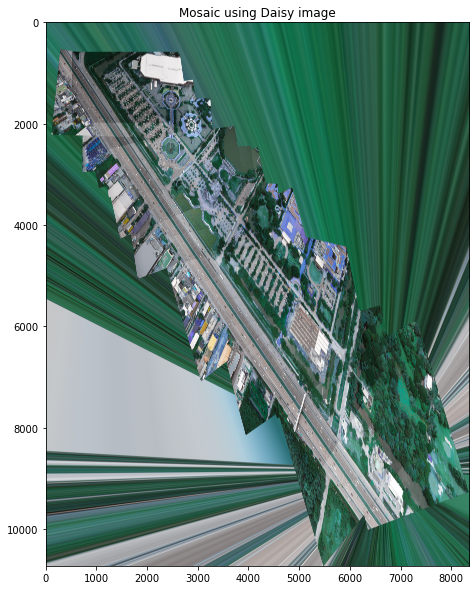

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_daisy)
plt.title('Mosaic using Daisy image')

# For Star 110 images

In [21]:
star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]


keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for imgs in tqdm(images_left_bgr):
    kpt = star.detect(imgs,None)
    kpt,descrip = brief.compute(imgs, kpt)
    keypoints_all_left_star.append(kpt)
    descriptors_all_left_brief.append(descrip)
    points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = star.detect(imgs,None)
    kpt,descrip = brief.compute(imgs, kpt)
    keypoints_all_right_star.append(kpt)
    descriptors_all_right_brief.append(descrip)
    points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


In [31]:
num_kps_star = []
for j in tqdm(keypoints_all_right_star + keypoints_all_left_star):
  num_kps_star.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 62322.50it/s]


In [32]:
H_left_star = []
H_right_star = []

num_matches_star = []
num_good_matches_star = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
    H_left_star.append(H_a)
    num_good_matches_star.append(matches)
    num_good_matches_star.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
    H_right_star.append(H_a)
    num_matches_star.append(matches)
    num_good_matches_star.append(gd_matches) 

  2%|▏         | 1/51 [00:00<00:10,  4.76it/s]


Number of matches 6815
Number of matches After Lowe's Ratio 686
Number of Robust matches 312




  4%|▍         | 2/51 [00:00<00:10,  4.50it/s]


Number of matches 6920
Number of matches After Lowe's Ratio 392
Number of Robust matches 8




  6%|▌         | 3/51 [00:00<00:12,  3.84it/s]


Number of matches 7081
Number of matches After Lowe's Ratio 460
Number of Robust matches 92




  8%|▊         | 4/51 [00:01<00:11,  3.98it/s]


Number of matches 7254
Number of matches After Lowe's Ratio 709
Number of Robust matches 265




 10%|▉         | 5/51 [00:01<00:11,  4.05it/s]


Number of matches 6568
Number of matches After Lowe's Ratio 721
Number of Robust matches 351




 12%|█▏        | 6/51 [00:01<00:10,  4.23it/s]


Number of matches 6520
Number of matches After Lowe's Ratio 667
Number of Robust matches 276



Number of matches 6098
Number of matches After Lowe's Ratio 737


 16%|█▌        | 8/51 [00:01<00:09,  4.69it/s]

Number of Robust matches 392



Number of matches 6281
Number of matches After Lowe's Ratio 1387
Number of Robust matches 959




 18%|█▊        | 9/51 [00:02<00:08,  4.74it/s]


Number of matches 5984
Number of matches After Lowe's Ratio 1173
Number of Robust matches 764



Number of matches 6106
Number of matches After Lowe's Ratio 775


 20%|█▉        | 10/51 [00:02<00:08,  4.85it/s]

Number of Robust matches 385



Number of matches 6128
Number of matches After Lowe's Ratio 462


 24%|██▎       | 12/51 [00:02<00:08,  4.85it/s]

Number of Robust matches 102



Number of matches 5937
Number of matches After Lowe's Ratio 940
Number of Robust matches 486




 25%|██▌       | 13/51 [00:02<00:08,  4.71it/s]


Number of matches 6776
Number of matches After Lowe's Ratio 549
Number of Robust matches 101




 27%|██▋       | 14/51 [00:03<00:07,  4.67it/s]


Number of matches 6634
Number of matches After Lowe's Ratio 879
Number of Robust matches 364




 29%|██▉       | 15/51 [00:03<00:08,  4.37it/s]


Number of matches 7698
Number of matches After Lowe's Ratio 435
Number of Robust matches 8




 31%|███▏      | 16/51 [00:03<00:08,  4.12it/s]


Number of matches 6518
Number of matches After Lowe's Ratio 370
Number of Robust matches 6




 33%|███▎      | 17/51 [00:03<00:08,  4.20it/s]


Number of matches 7166
Number of matches After Lowe's Ratio 780
Number of Robust matches 247




 35%|███▌      | 18/51 [00:04<00:08,  4.06it/s]


Number of matches 6884
Number of matches After Lowe's Ratio 422
Number of Robust matches 9




 37%|███▋      | 19/51 [00:04<00:08,  3.90it/s]


Number of matches 8652
Number of matches After Lowe's Ratio 444
Number of Robust matches 6




 39%|███▉      | 20/51 [00:04<00:08,  3.66it/s]


Number of matches 8409
Number of matches After Lowe's Ratio 609
Number of Robust matches 93




 41%|████      | 21/51 [00:05<00:08,  3.54it/s]


Number of matches 8440
Number of matches After Lowe's Ratio 521
Number of Robust matches 29




 43%|████▎     | 22/51 [00:05<00:08,  3.47it/s]


Number of matches 6586
Number of matches After Lowe's Ratio 359
Number of Robust matches 6




 45%|████▌     | 23/51 [00:05<00:07,  3.79it/s]


Number of matches 6515
Number of matches After Lowe's Ratio 718
Number of Robust matches 254



Number of matches 5704
Number of matches After Lowe's Ratio 701


 49%|████▉     | 25/51 [00:05<00:05,  4.42it/s]

Number of Robust matches 270



Number of matches 6521
Number of matches After Lowe's Ratio 755
Number of Robust matches 247




 51%|█████     | 26/51 [00:06<00:06,  3.94it/s]


Number of matches 8904
Number of matches After Lowe's Ratio 816
Number of Robust matches 239




 53%|█████▎    | 27/51 [00:06<00:06,  3.69it/s]


Number of matches 10618
Number of matches After Lowe's Ratio 1219
Number of Robust matches 361




 55%|█████▍    | 28/51 [00:06<00:06,  3.30it/s]


Number of matches 11978
Number of matches After Lowe's Ratio 1417
Number of Robust matches 474




 57%|█████▋    | 29/51 [00:07<00:07,  2.97it/s]


Number of matches 10003
Number of matches After Lowe's Ratio 1266
Number of Robust matches 423




 59%|█████▉    | 30/51 [00:07<00:06,  3.03it/s]


Number of matches 8548
Number of matches After Lowe's Ratio 1161
Number of Robust matches 441




 61%|██████    | 31/51 [00:07<00:06,  3.19it/s]


Number of matches 7462
Number of matches After Lowe's Ratio 1278
Number of Robust matches 567




 63%|██████▎   | 32/51 [00:08<00:05,  3.47it/s]


Number of matches 6531
Number of matches After Lowe's Ratio 1199
Number of Robust matches 701




 65%|██████▍   | 33/51 [00:08<00:04,  3.74it/s]


Number of matches 6637
Number of matches After Lowe's Ratio 1187
Number of Robust matches 680



Number of matches 7057

 67%|██████▋   | 34/51 [00:08<00:04,  4.01it/s]


Number of matches After Lowe's Ratio 1192
Number of Robust matches 697




 69%|██████▊   | 35/51 [00:08<00:03,  4.14it/s]


Number of matches 7222
Number of matches After Lowe's Ratio 1240
Number of Robust matches 547




 71%|███████   | 36/51 [00:09<00:03,  4.19it/s]


Number of matches 7095
Number of matches After Lowe's Ratio 1266
Number of Robust matches 643




 73%|███████▎  | 37/51 [00:09<00:03,  4.26it/s]


Number of matches 6964
Number of matches After Lowe's Ratio 1046
Number of Robust matches 440




 75%|███████▍  | 38/51 [00:09<00:03,  4.33it/s]


Number of matches 6391
Number of matches After Lowe's Ratio 696
Number of Robust matches 224



Number of matches 6220
Number of matches After Lowe's Ratio 1454


 76%|███████▋  | 39/51 [00:09<00:02,  4.56it/s]

Number of Robust matches 949




 78%|███████▊  | 40/51 [00:09<00:02,  4.20it/s]


Number of matches 6637
Number of matches After Lowe's Ratio 1135
Number of Robust matches 675



Number of matches 5955
Number of matches After Lowe's Ratio 871


 82%|████████▏ | 42/51 [00:10<00:01,  4.58it/s]

Number of Robust matches 471



Number of matches 6699
Number of matches After Lowe's Ratio 976
Number of Robust matches 520




 84%|████████▍ | 43/51 [00:10<00:01,  4.64it/s]


Number of matches 6684
Number of matches After Lowe's Ratio 1313
Number of Robust matches 816




 86%|████████▋ | 44/51 [00:10<00:01,  4.60it/s]


Number of matches 6654
Number of matches After Lowe's Ratio 565
Number of Robust matches 216




 88%|████████▊ | 45/51 [00:11<00:01,  4.63it/s]


Number of matches 6363
Number of matches After Lowe's Ratio 462
Number of Robust matches 139




 90%|█████████ | 46/51 [00:11<00:01,  4.74it/s]


Number of matches 6030
Number of matches After Lowe's Ratio 678
Number of Robust matches 224



Number of matches 6742
Number of matches After Lowe's Ratio 675


 92%|█████████▏| 47/51 [00:11<00:00,  4.78it/s]

Number of Robust matches 211




 94%|█████████▍| 48/51 [00:11<00:00,  4.46it/s]


Number of matches 7144
Number of matches After Lowe's Ratio 625
Number of Robust matches 120




 96%|█████████▌| 49/51 [00:11<00:00,  4.29it/s]


Number of matches 7263
Number of matches After Lowe's Ratio 817
Number of Robust matches 201




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 5783
Number of matches After Lowe's Ratio 317
Number of Robust matches 12




  2%|▏         | 1/59 [00:00<00:15,  3.75it/s]


Number of matches 5057
Number of matches After Lowe's Ratio 425
Number of Robust matches 110



Number of matches 7374
Number of matches After Lowe's Ratio 597


  3%|▎         | 2/59 [00:00<00:14,  4.06it/s]

Number of Robust matches 157




  5%|▌         | 3/59 [00:00<00:14,  3.93it/s]


Number of matches 6352
Number of matches After Lowe's Ratio 328
Number of Robust matches 26




  7%|▋         | 4/59 [00:00<00:13,  4.03it/s]


Number of matches 6567
Number of matches After Lowe's Ratio 451
Number of Robust matches 70




  8%|▊         | 5/59 [00:01<00:13,  4.01it/s]


Number of matches 6608
Number of matches After Lowe's Ratio 356
Number of Robust matches 17




 10%|█         | 6/59 [00:01<00:12,  4.14it/s]


Number of matches 6557
Number of matches After Lowe's Ratio 778
Number of Robust matches 288




 12%|█▏        | 7/59 [00:01<00:12,  4.05it/s]


Number of matches 7657
Number of matches After Lowe's Ratio 398
Number of Robust matches 8




 14%|█▎        | 8/59 [00:01<00:13,  3.91it/s]


Number of matches 5299
Number of matches After Lowe's Ratio 354
Number of Robust matches 11




 15%|█▌        | 9/59 [00:02<00:12,  4.05it/s]


Number of matches 5892
Number of matches After Lowe's Ratio 355
Number of Robust matches 28




 17%|█▋        | 10/59 [00:02<00:11,  4.19it/s]


Number of matches 6607
Number of matches After Lowe's Ratio 545
Number of Robust matches 134




 19%|█▊        | 11/59 [00:02<00:12,  3.89it/s]


Number of matches 7280
Number of matches After Lowe's Ratio 1035
Number of Robust matches 517




 20%|██        | 12/59 [00:02<00:11,  4.01it/s]


Number of matches 6308
Number of matches After Lowe's Ratio 1066
Number of Robust matches 590



Number of matches 5562
Number of matches After Lowe's Ratio 583


 22%|██▏       | 13/59 [00:03<00:10,  4.29it/s]

Number of Robust matches 262



Number of matches 6545
Number of matches After Lowe's Ratio 471


 25%|██▌       | 15/59 [00:03<00:09,  4.53it/s]

Number of Robust matches 61



Number of matches 5071
Number of matches After Lowe's Ratio 646
Number of Robust matches 341




 27%|██▋       | 16/59 [00:03<00:09,  4.78it/s]


Number of matches 7030
Number of matches After Lowe's Ratio 618
Number of Robust matches 225




 29%|██▉       | 17/59 [00:03<00:09,  4.66it/s]


Number of matches 6967
Number of matches After Lowe's Ratio 935
Number of Robust matches 488




 31%|███       | 18/59 [00:04<00:08,  4.62it/s]


Number of matches 6635
Number of matches After Lowe's Ratio 1012
Number of Robust matches 552




 34%|███▍      | 20/59 [00:04<00:08,  4.81it/s]


Number of matches 6187
Number of matches After Lowe's Ratio 1035
Number of Robust matches 614



Number of matches 6019
Number of matches After Lowe's Ratio 1246
Number of Robust matches 808




 36%|███▌      | 21/59 [00:04<00:07,  4.84it/s]


Number of matches 6759
Number of matches After Lowe's Ratio 660
Number of Robust matches 232




 37%|███▋      | 22/59 [00:05<00:07,  4.75it/s]


Number of matches 7354
Number of matches After Lowe's Ratio 884
Number of Robust matches 377




 39%|███▉      | 23/59 [00:05<00:08,  4.48it/s]


Number of matches 7852
Number of matches After Lowe's Ratio 855
Number of Robust matches 361




 41%|████      | 24/59 [00:05<00:08,  4.18it/s]


Number of matches 8426
Number of matches After Lowe's Ratio 867
Number of Robust matches 273




 42%|████▏     | 25/59 [00:05<00:08,  3.88it/s]


Number of matches 8569
Number of matches After Lowe's Ratio 684
Number of Robust matches 172




 44%|████▍     | 26/59 [00:06<00:08,  3.75it/s]


Number of matches 7887
Number of matches After Lowe's Ratio 918
Number of Robust matches 326




 46%|████▌     | 27/59 [00:06<00:08,  3.68it/s]


Number of matches 7352
Number of matches After Lowe's Ratio 876
Number of Robust matches 267




 47%|████▋     | 28/59 [00:06<00:08,  3.79it/s]


Number of matches 7423
Number of matches After Lowe's Ratio 1122
Number of Robust matches 395




 49%|████▉     | 29/59 [00:06<00:07,  3.85it/s]


Number of matches 6930
Number of matches After Lowe's Ratio 1106
Number of Robust matches 318




 51%|█████     | 30/59 [00:07<00:08,  3.48it/s]


Number of matches 6894
Number of matches After Lowe's Ratio 589
Number of Robust matches 113




 53%|█████▎    | 31/59 [00:07<00:07,  3.51it/s]


Number of matches 6802
Number of matches After Lowe's Ratio 570
Number of Robust matches 121




 54%|█████▍    | 32/59 [00:07<00:07,  3.50it/s]


Number of matches 10547
Number of matches After Lowe's Ratio 544
Number of Robust matches 6




 56%|█████▌    | 33/59 [00:08<00:08,  3.15it/s]


Number of matches 9644
Number of matches After Lowe's Ratio 770
Number of Robust matches 145




 58%|█████▊    | 34/59 [00:08<00:08,  3.02it/s]


Number of matches 10942
Number of matches After Lowe's Ratio 617
Number of Robust matches 5




 59%|█████▉    | 35/59 [00:09<00:08,  2.85it/s]


Number of matches 8681
Number of matches After Lowe's Ratio 750
Number of Robust matches 101




 61%|██████    | 36/59 [00:09<00:07,  2.94it/s]


Number of matches 7457
Number of matches After Lowe's Ratio 663
Number of Robust matches 70




 63%|██████▎   | 37/59 [00:09<00:06,  3.15it/s]


Number of matches 6732
Number of matches After Lowe's Ratio 990
Number of Robust matches 255




 64%|██████▍   | 38/59 [00:09<00:06,  3.35it/s]


Number of matches 6593
Number of matches After Lowe's Ratio 611
Number of Robust matches 143




 66%|██████▌   | 39/59 [00:10<00:05,  3.50it/s]


Number of matches 7130
Number of matches After Lowe's Ratio 751
Number of Robust matches 128




 68%|██████▊   | 40/59 [00:10<00:05,  3.60it/s]


Number of matches 7516
Number of matches After Lowe's Ratio 895
Number of Robust matches 249




 69%|██████▉   | 41/59 [00:10<00:04,  3.74it/s]


Number of matches 7371
Number of matches After Lowe's Ratio 1512
Number of Robust matches 565




 71%|███████   | 42/59 [00:10<00:04,  3.80it/s]


Number of matches 7839
Number of matches After Lowe's Ratio 838
Number of Robust matches 253




 73%|███████▎  | 43/59 [00:11<00:04,  3.71it/s]


Number of matches 7208
Number of matches After Lowe's Ratio 421
Number of Robust matches 6




 75%|███████▍  | 44/59 [00:11<00:04,  3.45it/s]


Number of matches 6916
Number of matches After Lowe's Ratio 658
Number of Robust matches 180




 76%|███████▋  | 45/59 [00:11<00:03,  3.65it/s]


Number of matches 6160
Number of matches After Lowe's Ratio 596
Number of Robust matches 172




 78%|███████▊  | 46/59 [00:11<00:03,  3.93it/s]


Number of matches 5951
Number of matches After Lowe's Ratio 479
Number of Robust matches 150



Number of matches 6068
Number of matches After Lowe's Ratio 580


 81%|████████▏ | 48/59 [00:12<00:02,  4.48it/s]

Number of Robust matches 229



Number of matches 5391
Number of matches After Lowe's Ratio 533
Number of Robust matches 179




 85%|████████▍ | 50/59 [00:12<00:01,  5.00it/s]


Number of matches 5254
Number of matches After Lowe's Ratio 1084
Number of Robust matches 650



Number of matches 5981
Number of matches After Lowe's Ratio 676
Number of Robust matches 218




 88%|████████▊ | 52/59 [00:13<00:01,  5.35it/s]


Number of matches 5843
Number of matches After Lowe's Ratio 897
Number of Robust matches 446



Number of matches 3483
Number of matches After Lowe's Ratio 416
Number of Robust matches 218




 93%|█████████▎| 55/59 [00:13<00:00,  7.00it/s]


Number of matches 2951
Number of matches After Lowe's Ratio 410
Number of Robust matches 192



Number of matches 2836
Number of matches After Lowe's Ratio 365
Number of Robust matches 194



Number of matches 2993
Number of matches After Lowe's Ratio 525
Number of Robust matches 261




 97%|█████████▋| 57/59 [00:13<00:00,  6.78it/s]


Number of matches 5209
Number of matches After Lowe's Ratio 619
Number of Robust matches 329



Number of matches 6095
Number of matches After Lowe's Ratio 1007
Number of Robust matches 539




 98%|█████████▊| 58/59 [00:13<00:00,  6.20it/s]


Number of matches 6031
Number of matches After Lowe's Ratio 1052
Number of Robust matches 527




In [35]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_star,H_right_star)

Step1:Done
Step2:Done


In [36]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_star,xmax,xmin,ymax,ymin,t,h,w,Ht)


step31:Done


In [37]:
warp_imgs_all_star = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_star,xmax,xmin,ymax,ymin,t,h,w,Ht)

step32:Done


Text(0.5, 1.0, '120-Images Mosaic-STAR')

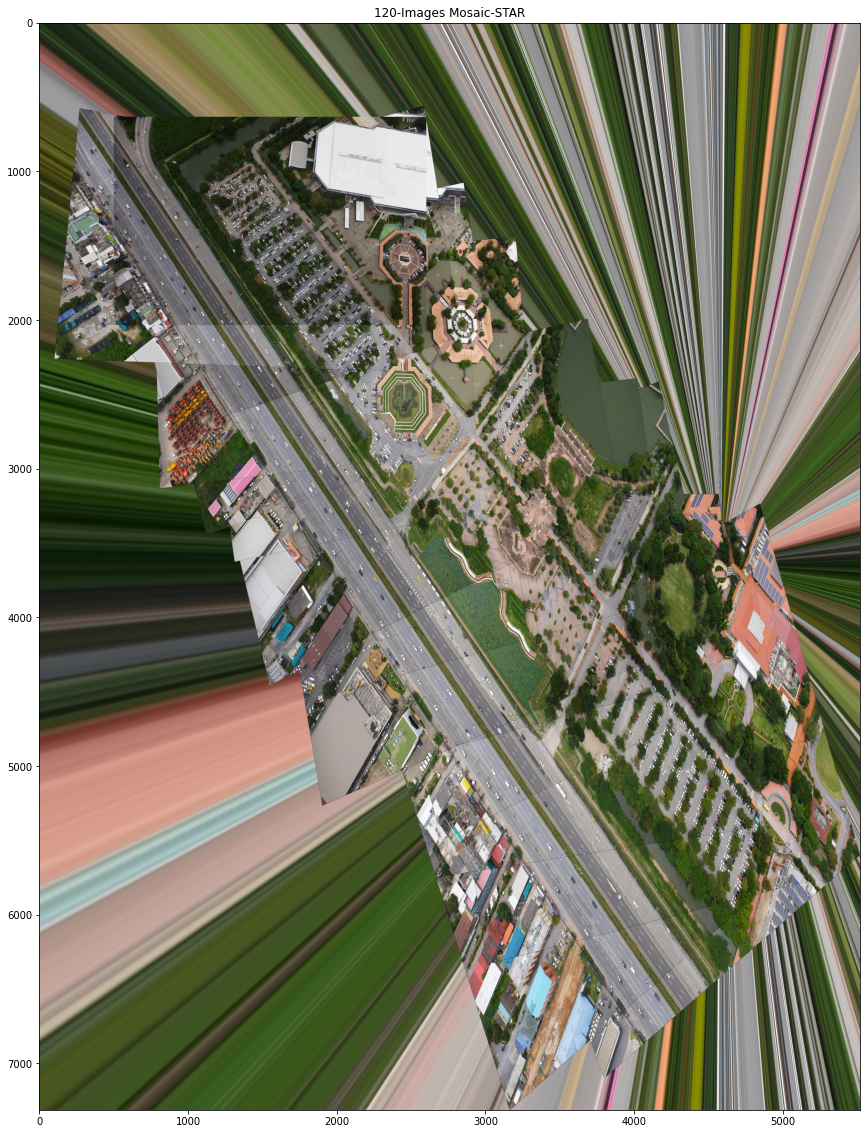

In [38]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_star , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-STAR')

# For Freak 110 image

In [10]:
Threshl=60;
Octaves=8;
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)
freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]


keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]

for imgs in tqdm(images_left_bgr):
    kpt = brisk.detect(imgs)
    kpt,descrip = freak.compute(imgs, kpt)
    keypoints_all_left_freak.append(kpt)
    descriptors_all_left_freak.append(descrip)
    points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = freak.compute(imgs, kpt)
    keypoints_all_right_freak.append(kpt)
    descriptors_all_right_freak.append(descrip)
    points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:42<00:00,  1.38it/s]


In [16]:
num_kps_freak = []
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak):
  num_kps_freak.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 45370.58it/s]


In [20]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1])
    H_left_freak.append(H_a)
    num_matches_freak.append(matches)
    num_good_matches_freak.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1])
    H_right_freak.append(H_a)
    num_matches_freak.append(matches)
    num_good_matches_freak.append(gd_matches)    
    

  2%|▏         | 1/51 [00:02<01:46,  2.14s/it]


Number of matches 30963
Number of matches After Lowe's Ratio 1970
Number of Robust matches 998




  4%|▍         | 2/51 [00:04<01:52,  2.30s/it]


Number of matches 30334
Number of matches After Lowe's Ratio 1980
Number of Robust matches 1083




  6%|▌         | 3/51 [00:07<01:59,  2.48s/it]


Number of matches 35225
Number of matches After Lowe's Ratio 2068
Number of Robust matches 1011




  8%|▊         | 4/51 [00:10<02:06,  2.70s/it]


Number of matches 34588
Number of matches After Lowe's Ratio 2717
Number of Robust matches 1790




 10%|▉         | 5/51 [00:14<02:14,  2.92s/it]


Number of matches 32541
Number of matches After Lowe's Ratio 2194
Number of Robust matches 1191




 12%|█▏        | 6/51 [00:17<02:13,  2.97s/it]


Number of matches 28721
Number of matches After Lowe's Ratio 2154
Number of Robust matches 1283




 14%|█▎        | 7/51 [00:19<02:04,  2.83s/it]


Number of matches 30225
Number of matches After Lowe's Ratio 2180
Number of Robust matches 1260




 16%|█▌        | 8/51 [00:23<02:04,  2.90s/it]


Number of matches 30991
Number of matches After Lowe's Ratio 2562
Number of Robust matches 1690




 18%|█▊        | 9/51 [00:25<02:01,  2.90s/it]


Number of matches 29265
Number of matches After Lowe's Ratio 2753
Number of Robust matches 1811




 20%|█▉        | 10/51 [00:28<01:56,  2.85s/it]


Number of matches 29356
Number of matches After Lowe's Ratio 2185
Number of Robust matches 1215




 22%|██▏       | 11/51 [00:31<01:54,  2.86s/it]


Number of matches 30010
Number of matches After Lowe's Ratio 1740
Number of Robust matches 848




 24%|██▎       | 12/51 [00:34<01:47,  2.77s/it]


Number of matches 29570
Number of matches After Lowe's Ratio 1905
Number of Robust matches 832




 25%|██▌       | 13/51 [00:36<01:43,  2.71s/it]


Number of matches 30831
Number of matches After Lowe's Ratio 2026
Number of Robust matches 1013




 27%|██▋       | 14/51 [00:39<01:42,  2.76s/it]


Number of matches 33305
Number of matches After Lowe's Ratio 1784
Number of Robust matches 824




 29%|██▉       | 15/51 [00:43<01:48,  3.01s/it]


Number of matches 41880
Number of matches After Lowe's Ratio 1848
Number of Robust matches 594




 31%|███▏      | 16/51 [00:47<01:56,  3.32s/it]


Number of matches 35904
Number of matches After Lowe's Ratio 1773
Number of Robust matches 534




 33%|███▎      | 17/51 [00:50<01:52,  3.29s/it]


Number of matches 30389
Number of matches After Lowe's Ratio 1638
Number of Robust matches 593




 35%|███▌      | 18/51 [00:52<01:41,  3.07s/it]


Number of matches 28704
Number of matches After Lowe's Ratio 1350
Number of Robust matches 383




 37%|███▋      | 19/51 [00:55<01:33,  2.92s/it]


Number of matches 31542
Number of matches After Lowe's Ratio 999
Number of Robust matches 224




 39%|███▉      | 20/51 [00:58<01:30,  2.93s/it]


Number of matches 31853
Number of matches After Lowe's Ratio 1341
Number of Robust matches 459




 41%|████      | 21/51 [01:01<01:27,  2.90s/it]


Number of matches 32825
Number of matches After Lowe's Ratio 818
Number of Robust matches 149




 43%|████▎     | 22/51 [01:03<01:21,  2.82s/it]


Number of matches 22605
Number of matches After Lowe's Ratio 526
Number of Robust matches 10




 45%|████▌     | 23/51 [01:05<01:11,  2.55s/it]


Number of matches 23139
Number of matches After Lowe's Ratio 1355
Number of Robust matches 464




 47%|████▋     | 24/51 [01:07<01:02,  2.31s/it]


Number of matches 19638
Number of matches After Lowe's Ratio 1291
Number of Robust matches 501




 49%|████▉     | 25/51 [01:09<00:54,  2.08s/it]


Number of matches 24280
Number of matches After Lowe's Ratio 1278
Number of Robust matches 475




 51%|█████     | 26/51 [01:11<00:52,  2.10s/it]


Number of matches 29286
Number of matches After Lowe's Ratio 1589
Number of Robust matches 514




 53%|█████▎    | 27/51 [01:14<00:58,  2.44s/it]


Number of matches 41948
Number of matches After Lowe's Ratio 1685
Number of Robust matches 448




 55%|█████▍    | 28/51 [01:19<01:10,  3.08s/it]


Number of matches 45777
Number of matches After Lowe's Ratio 2087
Number of Robust matches 616




 57%|█████▋    | 29/51 [01:23<01:19,  3.61s/it]


Number of matches 41498
Number of matches After Lowe's Ratio 1885
Number of Robust matches 539




 59%|█████▉    | 30/51 [01:27<01:17,  3.67s/it]


Number of matches 32765
Number of matches After Lowe's Ratio 1846
Number of Robust matches 689




 61%|██████    | 31/51 [01:30<01:09,  3.46s/it]


Number of matches 30811
Number of matches After Lowe's Ratio 2073
Number of Robust matches 1017




 63%|██████▎   | 32/51 [01:33<01:01,  3.22s/it]


Number of matches 28921
Number of matches After Lowe's Ratio 2098
Number of Robust matches 1031




 65%|██████▍   | 33/51 [01:35<00:53,  2.98s/it]


Number of matches 28541
Number of matches After Lowe's Ratio 2295
Number of Robust matches 1286




 67%|██████▋   | 34/51 [01:38<00:49,  2.90s/it]


Number of matches 34315
Number of matches After Lowe's Ratio 2270
Number of Robust matches 1120




 69%|██████▊   | 35/51 [01:41<00:48,  3.04s/it]


Number of matches 37159
Number of matches After Lowe's Ratio 2652
Number of Robust matches 1232




 71%|███████   | 36/51 [01:45<00:47,  3.17s/it]


Number of matches 35439
Number of matches After Lowe's Ratio 2555
Number of Robust matches 1194




 73%|███████▎  | 37/51 [01:48<00:45,  3.25s/it]


Number of matches 36939
Number of matches After Lowe's Ratio 2534
Number of Robust matches 1110




 75%|███████▍  | 38/51 [01:52<00:42,  3.30s/it]


Number of matches 30760
Number of matches After Lowe's Ratio 1631
Number of Robust matches 762




 76%|███████▋  | 39/51 [01:54<00:36,  3.08s/it]


Number of matches 29514
Number of matches After Lowe's Ratio 2922
Number of Robust matches 1733




 78%|███████▊  | 40/51 [01:57<00:32,  2.94s/it]


Number of matches 28402
Number of matches After Lowe's Ratio 2484
Number of Robust matches 1502




 80%|████████  | 41/51 [01:59<00:27,  2.77s/it]


Number of matches 25855
Number of matches After Lowe's Ratio 1480
Number of Robust matches 693




 82%|████████▏ | 42/51 [02:01<00:23,  2.58s/it]


Number of matches 25442
Number of matches After Lowe's Ratio 1495
Number of Robust matches 756




 84%|████████▍ | 43/51 [02:04<00:19,  2.47s/it]


Number of matches 25540
Number of matches After Lowe's Ratio 1955
Number of Robust matches 1092




 86%|████████▋ | 44/51 [02:06<00:16,  2.42s/it]


Number of matches 31109
Number of matches After Lowe's Ratio 1898
Number of Robust matches 849




 88%|████████▊ | 45/51 [02:08<00:14,  2.46s/it]


Number of matches 25420
Number of matches After Lowe's Ratio 1816
Number of Robust matches 903




 90%|█████████ | 46/51 [02:11<00:11,  2.37s/it]


Number of matches 27131
Number of matches After Lowe's Ratio 1686
Number of Robust matches 591




 92%|█████████▏| 47/51 [02:13<00:09,  2.40s/it]


Number of matches 30777
Number of matches After Lowe's Ratio 2543
Number of Robust matches 944




 94%|█████████▍| 48/51 [02:16<00:07,  2.54s/it]


Number of matches 31215
Number of matches After Lowe's Ratio 1660
Number of Robust matches 497




 96%|█████████▌| 49/51 [02:19<00:05,  2.70s/it]


Number of matches 34016
Number of matches After Lowe's Ratio 2589
Number of Robust matches 759




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 23270
Number of matches After Lowe's Ratio 855
Number of Robust matches 141




  2%|▏         | 1/59 [00:02<02:09,  2.24s/it]


Number of matches 20799
Number of matches After Lowe's Ratio 1348
Number of Robust matches 691




  3%|▎         | 2/59 [00:03<01:59,  2.09s/it]


Number of matches 29762
Number of matches After Lowe's Ratio 1249
Number of Robust matches 394




  5%|▌         | 3/59 [00:06<02:05,  2.24s/it]


Number of matches 24534
Number of matches After Lowe's Ratio 1502
Number of Robust matches 695




  7%|▋         | 4/59 [00:08<02:00,  2.19s/it]


Number of matches 26179
Number of matches After Lowe's Ratio 1573
Number of Robust matches 507




  8%|▊         | 5/59 [00:10<01:55,  2.14s/it]


Number of matches 21791
Number of matches After Lowe's Ratio 1382
Number of Robust matches 582




 10%|█         | 6/59 [00:12<01:47,  2.03s/it]


Number of matches 23985
Number of matches After Lowe's Ratio 1392
Number of Robust matches 503




 12%|█▏        | 7/59 [00:14<01:47,  2.06s/it]


Number of matches 29091
Number of matches After Lowe's Ratio 737
Number of Robust matches 9




 14%|█▎        | 8/59 [00:16<01:49,  2.14s/it]


Number of matches 23038
Number of matches After Lowe's Ratio 773
Number of Robust matches 177




 15%|█▌        | 9/59 [00:18<01:42,  2.04s/it]


Number of matches 21727
Number of matches After Lowe's Ratio 715
Number of Robust matches 162




 17%|█▋        | 10/59 [00:20<01:35,  1.95s/it]


Number of matches 23257
Number of matches After Lowe's Ratio 896
Number of Robust matches 286




 19%|█▊        | 11/59 [00:22<01:38,  2.04s/it]


Number of matches 33002
Number of matches After Lowe's Ratio 1650
Number of Robust matches 703




 20%|██        | 12/59 [00:25<01:45,  2.25s/it]


Number of matches 26873
Number of matches After Lowe's Ratio 1877
Number of Robust matches 1132




 22%|██▏       | 13/59 [00:27<01:41,  2.22s/it]


Number of matches 24439
Number of matches After Lowe's Ratio 1088
Number of Robust matches 496




 24%|██▎       | 14/59 [00:29<01:35,  2.13s/it]


Number of matches 22762
Number of matches After Lowe's Ratio 660
Number of Robust matches 171




 25%|██▌       | 15/59 [00:31<01:30,  2.05s/it]


Number of matches 19743
Number of matches After Lowe's Ratio 1429
Number of Robust matches 876




 27%|██▋       | 16/59 [00:33<01:23,  1.94s/it]


Number of matches 29263
Number of matches After Lowe's Ratio 1191
Number of Robust matches 440




 29%|██▉       | 17/59 [00:35<01:30,  2.14s/it]


Number of matches 29662
Number of matches After Lowe's Ratio 2303
Number of Robust matches 1531




 31%|███       | 18/59 [00:38<01:36,  2.36s/it]


Number of matches 31340
Number of matches After Lowe's Ratio 2415
Number of Robust matches 1565




 32%|███▏      | 19/59 [00:41<01:40,  2.50s/it]


Number of matches 28069
Number of matches After Lowe's Ratio 1957
Number of Robust matches 1297




 34%|███▍      | 20/59 [00:43<01:38,  2.52s/it]


Number of matches 30957
Number of matches After Lowe's Ratio 2203
Number of Robust matches 1468




 36%|███▌      | 21/59 [00:46<01:40,  2.64s/it]


Number of matches 30565
Number of matches After Lowe's Ratio 1710
Number of Robust matches 932




 37%|███▋      | 22/59 [00:49<01:39,  2.69s/it]


Number of matches 32974
Number of matches After Lowe's Ratio 2144
Number of Robust matches 1194




 39%|███▉      | 23/59 [00:52<01:40,  2.80s/it]


Number of matches 36549
Number of matches After Lowe's Ratio 2049
Number of Robust matches 1035




 41%|████      | 24/59 [00:56<01:45,  3.02s/it]


Number of matches 35159
Number of matches After Lowe's Ratio 2159
Number of Robust matches 1048




 42%|████▏     | 25/59 [00:59<01:47,  3.17s/it]


Number of matches 38169
Number of matches After Lowe's Ratio 2375
Number of Robust matches 1067




 44%|████▍     | 26/59 [01:03<01:49,  3.31s/it]


Number of matches 33493
Number of matches After Lowe's Ratio 2166
Number of Robust matches 918




 46%|████▌     | 27/59 [01:06<01:41,  3.17s/it]


Number of matches 27254
Number of matches After Lowe's Ratio 1758
Number of Robust matches 608




 47%|████▋     | 28/59 [01:08<01:30,  2.92s/it]


Number of matches 29921
Number of matches After Lowe's Ratio 1991
Number of Robust matches 627




 49%|████▉     | 29/59 [01:11<01:25,  2.85s/it]


Number of matches 27914
Number of matches After Lowe's Ratio 1909
Number of Robust matches 524




 51%|█████     | 30/59 [01:13<01:17,  2.67s/it]


Number of matches 22382
Number of matches After Lowe's Ratio 1357
Number of Robust matches 472




 53%|█████▎    | 31/59 [01:15<01:07,  2.43s/it]


Number of matches 26806
Number of matches After Lowe's Ratio 1362
Number of Robust matches 510




 54%|█████▍    | 32/59 [01:18<01:08,  2.53s/it]


Number of matches 43407
Number of matches After Lowe's Ratio 896
Number of Robust matches 53




 56%|█████▌    | 33/59 [01:22<01:19,  3.07s/it]


Number of matches 39639
Number of matches After Lowe's Ratio 1050
Number of Robust matches 276




 58%|█████▊    | 34/59 [01:26<01:25,  3.42s/it]


Number of matches 44415
Number of matches After Lowe's Ratio 776
Number of Robust matches 6




 59%|█████▉    | 35/59 [01:30<01:28,  3.67s/it]


Number of matches 34575
Number of matches After Lowe's Ratio 999
Number of Robust matches 182




 61%|██████    | 36/59 [01:34<01:21,  3.53s/it]


Number of matches 32318
Number of matches After Lowe's Ratio 1710
Number of Robust matches 528




 63%|██████▎   | 37/59 [01:37<01:13,  3.33s/it]


Number of matches 30468
Number of matches After Lowe's Ratio 1780
Number of Robust matches 501




 64%|██████▍   | 38/59 [01:39<01:06,  3.16s/it]


Number of matches 26838
Number of matches After Lowe's Ratio 1500
Number of Robust matches 407




 66%|██████▌   | 39/59 [01:41<00:57,  2.86s/it]


Number of matches 24184
Number of matches After Lowe's Ratio 1182
Number of Robust matches 290




 68%|██████▊   | 40/59 [01:44<00:49,  2.61s/it]


Number of matches 25941
Number of matches After Lowe's Ratio 1171
Number of Robust matches 287




 69%|██████▉   | 41/59 [01:46<00:45,  2.54s/it]


Number of matches 27985
Number of matches After Lowe's Ratio 2156
Number of Robust matches 659




 71%|███████   | 42/59 [01:48<00:43,  2.54s/it]


Number of matches 29906
Number of matches After Lowe's Ratio 1365
Number of Robust matches 323




 73%|███████▎  | 43/59 [01:51<00:40,  2.54s/it]


Number of matches 26647
Number of matches After Lowe's Ratio 1665
Number of Robust matches 590




 75%|███████▍  | 44/59 [01:53<00:37,  2.51s/it]


Number of matches 30823
Number of matches After Lowe's Ratio 1779
Number of Robust matches 579




 76%|███████▋  | 45/59 [01:56<00:35,  2.52s/it]


Number of matches 23861
Number of matches After Lowe's Ratio 1320
Number of Robust matches 511




 78%|███████▊  | 46/59 [01:58<00:30,  2.37s/it]


Number of matches 26390
Number of matches After Lowe's Ratio 1020
Number of Robust matches 488




 80%|███████▉  | 47/59 [02:00<00:27,  2.32s/it]


Number of matches 26937
Number of matches After Lowe's Ratio 1289
Number of Robust matches 735




 81%|████████▏ | 48/59 [02:03<00:25,  2.34s/it]


Number of matches 26134
Number of matches After Lowe's Ratio 1195
Number of Robust matches 629




 83%|████████▎ | 49/59 [02:05<00:22,  2.27s/it]


Number of matches 23810
Number of matches After Lowe's Ratio 1941
Number of Robust matches 1211




 85%|████████▍ | 50/59 [02:07<00:19,  2.16s/it]


Number of matches 23843
Number of matches After Lowe's Ratio 1186
Number of Robust matches 522




 86%|████████▋ | 51/59 [02:08<00:16,  2.09s/it]


Number of matches 24045
Number of matches After Lowe's Ratio 2078
Number of Robust matches 1285




 88%|████████▊ | 52/59 [02:10<00:13,  1.99s/it]


Number of matches 12316
Number of matches After Lowe's Ratio 627
Number of Robust matches 277




 90%|████████▉ | 53/59 [02:11<00:09,  1.61s/it]


Number of matches 8554
Number of matches After Lowe's Ratio 742
Number of Robust matches 417




 92%|█████████▏| 54/59 [02:11<00:06,  1.28s/it]


Number of matches 9986
Number of matches After Lowe's Ratio 500
Number of Robust matches 256




 93%|█████████▎| 55/59 [02:12<00:04,  1.08s/it]


Number of matches 11560
Number of matches After Lowe's Ratio 1186
Number of Robust matches 660




 95%|█████████▍| 56/59 [02:13<00:02,  1.00it/s]


Number of matches 21160
Number of matches After Lowe's Ratio 1169
Number of Robust matches 549




 97%|█████████▋| 57/59 [02:15<00:02,  1.21s/it]


Number of matches 24488
Number of matches After Lowe's Ratio 1811
Number of Robust matches 1005




 98%|█████████▊| 58/59 [02:17<00:01,  1.48s/it]


Number of matches 23402
Number of matches After Lowe's Ratio 1687
Number of Robust matches 851




In [23]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_freak,H_right_freak)

Step1:Done
Step2:Done


In [ ]:
warp_img = final_steps_left_union(images_left_bgr_no_enhance,H_left_freak,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
warp_imgs_all_freak = final_step_right_union(warp_img,images_right_bgr_no_enhance,H_right_freak,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_freak , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-Freak')

# For MSER 110 image

In [10]:
mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = mser.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_mser.append(kpt)
    descriptors_all_left_mser.append(descrip)
    points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = mser.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_mser.append(kpt)
    descriptors_all_right_mser.append(descrip)
    points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [05:07<00:00,  5.21s/it]


In [16]:
num_kps_mser = []
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser):
  num_kps_mser.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 49498.28it/s]


In [27]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1])
    H_left_mser.append(H_a)
    num_matches_mser.append(matches)
    num_good_matches_mser.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1])
    H_right_mser.append(H_a)
    num_matches_mser.append(matches)
    num_good_matches_mser.append(gd_matches)    
    


  4%|▍         | 2/51 [00:00<00:08,  6.08it/s]


Number of matches 1844
Number of matches After Lowe's Ratio 335
Number of Robust matches 157



Number of matches 1636
Number of matches After Lowe's Ratio 55
Number of Robust matches 21




  6%|▌         | 3/51 [00:00<00:08,  5.92it/s]


Number of matches 1977
Number of matches After Lowe's Ratio 172
Number of Robust matches 74



Number of matches 2022
Number of matches After Lowe's Ratio 292


 10%|▉         | 5/51 [00:00<00:08,  5.42it/s]

Number of Robust matches 173



Number of matches 1919
Number of matches After Lowe's Ratio 319
Number of Robust matches 202




 12%|█▏        | 6/51 [00:01<00:08,  5.20it/s]


Number of matches 2101
Number of matches After Lowe's Ratio 339
Number of Robust matches 190




 14%|█▎        | 7/51 [00:01<00:08,  4.90it/s]


Number of matches 2304
Number of matches After Lowe's Ratio 447
Number of Robust matches 225




 16%|█▌        | 8/51 [00:01<00:09,  4.62it/s]


Number of matches 2185
Number of matches After Lowe's Ratio 630
Number of Robust matches 278




 18%|█▊        | 9/51 [00:01<00:09,  4.49it/s]


Number of matches 2208
Number of matches After Lowe's Ratio 663
Number of Robust matches 298




 20%|█▉        | 10/51 [00:02<00:09,  4.38it/s]


Number of matches 2367
Number of matches After Lowe's Ratio 486
Number of Robust matches 254




 22%|██▏       | 11/51 [00:02<00:09,  4.15it/s]


Number of matches 2393
Number of matches After Lowe's Ratio 267
Number of Robust matches 118




 24%|██▎       | 12/51 [00:02<00:09,  4.01it/s]


Number of matches 2359
Number of matches After Lowe's Ratio 540
Number of Robust matches 216




 25%|██▌       | 13/51 [00:02<00:09,  3.98it/s]


Number of matches 2461
Number of matches After Lowe's Ratio 307
Number of Robust matches 140




 27%|██▋       | 14/51 [00:03<00:09,  3.92it/s]


Number of matches 2249
Number of matches After Lowe's Ratio 470
Number of Robust matches 190




 29%|██▉       | 15/51 [00:03<00:08,  4.01it/s]


Number of matches 2372
Number of matches After Lowe's Ratio 8
Number of Robust matches 4




 31%|███▏      | 16/51 [00:03<00:08,  4.02it/s]


Number of matches 2069
Number of matches After Lowe's Ratio 41
Number of Robust matches 16




 33%|███▎      | 17/51 [00:03<00:08,  4.06it/s]


Number of matches 2359
Number of matches After Lowe's Ratio 501
Number of Robust matches 126




 35%|███▌      | 18/51 [00:04<00:08,  3.95it/s]


Number of matches 2766
Number of matches After Lowe's Ratio 65
Number of Robust matches 20




 37%|███▋      | 19/51 [00:04<00:08,  3.65it/s]


Number of matches 3058
Number of matches After Lowe's Ratio 46
Number of Robust matches 12




 39%|███▉      | 20/51 [00:04<00:09,  3.39it/s]


Number of matches 3085
Number of matches After Lowe's Ratio 406
Number of Robust matches 120




 41%|████      | 21/51 [00:05<00:09,  3.18it/s]


Number of matches 3255
Number of matches After Lowe's Ratio 245
Number of Robust matches 68




 43%|████▎     | 22/51 [00:05<00:09,  3.06it/s]


Number of matches 2861
Number of matches After Lowe's Ratio 8
Number of Robust matches 5




 45%|████▌     | 23/51 [00:05<00:09,  3.11it/s]


Number of matches 2662
Number of matches After Lowe's Ratio 454
Number of Robust matches 146




 47%|████▋     | 24/51 [00:06<00:08,  3.06it/s]


Number of matches 2577
Number of matches After Lowe's Ratio 536
Number of Robust matches 186




 49%|████▉     | 25/51 [00:06<00:08,  3.04it/s]


Number of matches 2927
Number of matches After Lowe's Ratio 444
Number of Robust matches 147




 51%|█████     | 26/51 [00:06<00:08,  2.97it/s]


Number of matches 3331
Number of matches After Lowe's Ratio 535
Number of Robust matches 169




 53%|█████▎    | 27/51 [00:07<00:08,  2.75it/s]


Number of matches 3499
Number of matches After Lowe's Ratio 487
Number of Robust matches 135




 55%|█████▍    | 28/51 [00:07<00:08,  2.59it/s]


Number of matches 3895
Number of matches After Lowe's Ratio 731
Number of Robust matches 259




 57%|█████▋    | 29/51 [00:08<00:08,  2.45it/s]


Number of matches 3345
Number of matches After Lowe's Ratio 623
Number of Robust matches 225




 59%|█████▉    | 30/51 [00:08<00:08,  2.50it/s]


Number of matches 2826
Number of matches After Lowe's Ratio 638
Number of Robust matches 232




 61%|██████    | 31/51 [00:08<00:07,  2.68it/s]


Number of matches 2607
Number of matches After Lowe's Ratio 617
Number of Robust matches 235




 63%|██████▎   | 32/51 [00:09<00:06,  2.89it/s]


Number of matches 2230
Number of matches After Lowe's Ratio 519
Number of Robust matches 236




 65%|██████▍   | 33/51 [00:09<00:05,  3.13it/s]


Number of matches 2359
Number of matches After Lowe's Ratio 590
Number of Robust matches 236




 67%|██████▋   | 34/51 [00:09<00:05,  3.27it/s]


Number of matches 2556
Number of matches After Lowe's Ratio 618
Number of Robust matches 264




 69%|██████▊   | 35/51 [00:09<00:04,  3.29it/s]


Number of matches 2370
Number of matches After Lowe's Ratio 627
Number of Robust matches 229




 71%|███████   | 36/51 [00:10<00:04,  3.46it/s]


Number of matches 2175
Number of matches After Lowe's Ratio 623
Number of Robust matches 289




 73%|███████▎  | 37/51 [00:10<00:03,  3.72it/s]


Number of matches 1943
Number of matches After Lowe's Ratio 490
Number of Robust matches 165




 76%|███████▋  | 39/51 [00:10<00:02,  4.34it/s]


Number of matches 1749
Number of matches After Lowe's Ratio 261
Number of Robust matches 132



Number of matches 1809
Number of matches After Lowe's Ratio 509
Number of Robust matches 235




 78%|███████▊  | 40/51 [00:11<00:02,  4.58it/s]


Number of matches 1908
Number of matches After Lowe's Ratio 443
Number of Robust matches 211



Number of matches 1778
Number of matches After Lowe's Ratio 375


 82%|████████▏ | 42/51 [00:11<00:01,  4.83it/s]

Number of Robust matches 165



Number of matches 2041
Number of matches After Lowe's Ratio 411
Number of Robust matches 173




 84%|████████▍ | 43/51 [00:11<00:01,  4.73it/s]


Number of matches 2214
Number of matches After Lowe's Ratio 636
Number of Robust matches 291




 86%|████████▋ | 44/51 [00:11<00:01,  4.65it/s]


Number of matches 2180
Number of matches After Lowe's Ratio 310
Number of Robust matches 137




 88%|████████▊ | 45/51 [00:12<00:01,  4.55it/s]


Number of matches 2265
Number of matches After Lowe's Ratio 287
Number of Robust matches 123




 90%|█████████ | 46/51 [00:12<00:01,  4.29it/s]


Number of matches 2489
Number of matches After Lowe's Ratio 423
Number of Robust matches 121




 92%|█████████▏| 47/51 [00:12<00:00,  4.11it/s]


Number of matches 2634
Number of matches After Lowe's Ratio 592
Number of Robust matches 220




 94%|█████████▍| 48/51 [00:12<00:00,  3.90it/s]


Number of matches 2578
Number of matches After Lowe's Ratio 324
Number of Robust matches 105




 96%|█████████▌| 49/51 [00:13<00:00,  3.81it/s]


Number of matches 2583
Number of matches After Lowe's Ratio 621
Number of Robust matches 202




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 2358
Number of matches After Lowe's Ratio 76
Number of Robust matches 31




  2%|▏         | 1/59 [00:00<00:16,  3.60it/s]


Number of matches 2122
Number of matches After Lowe's Ratio 271
Number of Robust matches 103




  3%|▎         | 2/59 [00:00<00:15,  3.66it/s]


Number of matches 2642
Number of matches After Lowe's Ratio 267
Number of Robust matches 97




  5%|▌         | 3/59 [00:00<00:15,  3.56it/s]


Number of matches 2570
Number of matches After Lowe's Ratio 158
Number of Robust matches 57




  7%|▋         | 4/59 [00:01<00:15,  3.44it/s]


Number of matches 2761
Number of matches After Lowe's Ratio 269
Number of Robust matches 83




  8%|▊         | 5/59 [00:01<00:16,  3.26it/s]


Number of matches 2847
Number of matches After Lowe's Ratio 142
Number of Robust matches 39




 10%|█         | 6/59 [00:01<00:16,  3.20it/s]


Number of matches 2731
Number of matches After Lowe's Ratio 541
Number of Robust matches 185




 12%|█▏        | 7/59 [00:02<00:16,  3.15it/s]


Number of matches 3077
Number of matches After Lowe's Ratio 19
Number of Robust matches 6




 14%|█▎        | 8/59 [00:02<00:16,  3.05it/s]


Number of matches 2649
Number of matches After Lowe's Ratio 186
Number of Robust matches 32




 15%|█▌        | 9/59 [00:02<00:16,  3.10it/s]


Number of matches 2573
Number of matches After Lowe's Ratio 221
Number of Robust matches 47




 17%|█▋        | 10/59 [00:03<00:15,  3.16it/s]


Number of matches 2515
Number of matches After Lowe's Ratio 196
Number of Robust matches 69




 19%|█▊        | 11/59 [00:03<00:14,  3.26it/s]


Number of matches 2578
Number of matches After Lowe's Ratio 342
Number of Robust matches 146




 22%|██▏       | 13/59 [00:03<00:12,  3.78it/s]


Number of matches 1782
Number of matches After Lowe's Ratio 381
Number of Robust matches 172



Number of matches 1452
Number of matches After Lowe's Ratio 177
Number of Robust matches 108




 24%|██▎       | 14/59 [00:04<00:10,  4.16it/s]


Number of matches 2306
Number of matches After Lowe's Ratio 139
Number of Robust matches 67




 25%|██▌       | 15/59 [00:04<00:10,  4.20it/s]


Number of matches 1911
Number of matches After Lowe's Ratio 463
Number of Robust matches 232




 27%|██▋       | 16/59 [00:04<00:10,  4.22it/s]


Number of matches 2142
Number of matches After Lowe's Ratio 254
Number of Robust matches 139




 29%|██▉       | 17/59 [00:04<00:09,  4.24it/s]


Number of matches 2191
Number of matches After Lowe's Ratio 595
Number of Robust matches 350




 31%|███       | 18/59 [00:04<00:09,  4.18it/s]


Number of matches 2029
Number of matches After Lowe's Ratio 533
Number of Robust matches 271




 32%|███▏      | 19/59 [00:05<00:09,  4.19it/s]


Number of matches 2512
Number of matches After Lowe's Ratio 593
Number of Robust matches 332




 34%|███▍      | 20/59 [00:05<00:09,  3.99it/s]


Number of matches 2412
Number of matches After Lowe's Ratio 669
Number of Robust matches 341




 36%|███▌      | 21/59 [00:05<00:09,  3.91it/s]


Number of matches 2826
Number of matches After Lowe's Ratio 365
Number of Robust matches 168




 37%|███▋      | 22/59 [00:06<00:10,  3.62it/s]


Number of matches 2981
Number of matches After Lowe's Ratio 587
Number of Robust matches 281




 39%|███▉      | 23/59 [00:06<00:10,  3.34it/s]


Number of matches 3041
Number of matches After Lowe's Ratio 596
Number of Robust matches 206




 41%|████      | 24/59 [00:06<00:10,  3.23it/s]


Number of matches 3227
Number of matches After Lowe's Ratio 693
Number of Robust matches 269




 42%|████▏     | 25/59 [00:07<00:11,  3.09it/s]


Number of matches 3127
Number of matches After Lowe's Ratio 538
Number of Robust matches 191




 44%|████▍     | 26/59 [00:07<00:10,  3.05it/s]


Number of matches 3082
Number of matches After Lowe's Ratio 753
Number of Robust matches 278




 46%|████▌     | 27/59 [00:07<00:10,  3.02it/s]


Number of matches 2828
Number of matches After Lowe's Ratio 581
Number of Robust matches 195




 47%|████▋     | 28/59 [00:08<00:10,  3.06it/s]


Number of matches 2804
Number of matches After Lowe's Ratio 746
Number of Robust matches 218




 49%|████▉     | 29/59 [00:08<00:09,  3.05it/s]


Number of matches 3047
Number of matches After Lowe's Ratio 702
Number of Robust matches 199




 51%|█████     | 30/59 [00:08<00:09,  3.01it/s]


Number of matches 3292
Number of matches After Lowe's Ratio 389
Number of Robust matches 132




 53%|█████▎    | 31/59 [00:09<00:09,  2.98it/s]


Number of matches 2865
Number of matches After Lowe's Ratio 329
Number of Robust matches 122




 54%|█████▍    | 32/59 [00:09<00:09,  2.98it/s]


Number of matches 3522
Number of matches After Lowe's Ratio 127
Number of Robust matches 43




 56%|█████▌    | 33/59 [00:09<00:09,  2.76it/s]


Number of matches 3409
Number of matches After Lowe's Ratio 523
Number of Robust matches 129




 58%|█████▊    | 34/59 [00:10<00:09,  2.72it/s]


Number of matches 3648
Number of matches After Lowe's Ratio 10
Number of Robust matches 4




 59%|█████▉    | 35/59 [00:10<00:09,  2.61it/s]


Number of matches 3290
Number of matches After Lowe's Ratio 371
Number of Robust matches 98




 61%|██████    | 36/59 [00:11<00:08,  2.67it/s]


Number of matches 3162
Number of matches After Lowe's Ratio 412
Number of Robust matches 134




 63%|██████▎   | 37/59 [00:11<00:07,  2.79it/s]


Number of matches 2667
Number of matches After Lowe's Ratio 593
Number of Robust matches 196




 64%|██████▍   | 38/59 [00:11<00:07,  2.95it/s]


Number of matches 3045
Number of matches After Lowe's Ratio 331
Number of Robust matches 126




 66%|██████▌   | 39/59 [00:12<00:06,  2.93it/s]


Number of matches 2955
Number of matches After Lowe's Ratio 367
Number of Robust matches 104




 68%|██████▊   | 40/59 [00:12<00:06,  2.98it/s]


Number of matches 2928
Number of matches After Lowe's Ratio 497
Number of Robust matches 171




 69%|██████▉   | 41/59 [00:12<00:05,  3.05it/s]


Number of matches 2889
Number of matches After Lowe's Ratio 869
Number of Robust matches 266




 71%|███████   | 42/59 [00:12<00:05,  3.03it/s]


Number of matches 2877
Number of matches After Lowe's Ratio 536
Number of Robust matches 171




 73%|███████▎  | 43/59 [00:13<00:05,  3.12it/s]


Number of matches 2724
Number of matches After Lowe's Ratio 68
Number of Robust matches 24




 75%|███████▍  | 44/59 [00:13<00:04,  3.20it/s]


Number of matches 2688
Number of matches After Lowe's Ratio 445
Number of Robust matches 154




 76%|███████▋  | 45/59 [00:13<00:04,  3.22it/s]


Number of matches 2695
Number of matches After Lowe's Ratio 307
Number of Robust matches 113




 78%|███████▊  | 46/59 [00:14<00:03,  3.33it/s]


Number of matches 2283
Number of matches After Lowe's Ratio 162
Number of Robust matches 85




 80%|███████▉  | 47/59 [00:14<00:03,  3.49it/s]


Number of matches 2330
Number of matches After Lowe's Ratio 349
Number of Robust matches 157




 81%|████████▏ | 48/59 [00:14<00:03,  3.64it/s]


Number of matches 2095
Number of matches After Lowe's Ratio 338
Number of Robust matches 154




 83%|████████▎ | 49/59 [00:14<00:02,  3.82it/s]


Number of matches 2164
Number of matches After Lowe's Ratio 653
Number of Robust matches 276




 85%|████████▍ | 50/59 [00:15<00:02,  3.93it/s]


Number of matches 2280
Number of matches After Lowe's Ratio 368
Number of Robust matches 153




 86%|████████▋ | 51/59 [00:15<00:02,  3.95it/s]


Number of matches 2267
Number of matches After Lowe's Ratio 653
Number of Robust matches 231




 90%|████████▉ | 53/59 [00:15<00:01,  4.39it/s]


Number of matches 1729
Number of matches After Lowe's Ratio 259
Number of Robust matches 96



Number of matches 1584
Number of matches After Lowe's Ratio 396
Number of Robust matches 135




 93%|█████████▎| 55/59 [00:16<00:00,  5.16it/s]


Number of matches 1530
Number of matches After Lowe's Ratio 217
Number of Robust matches 63



Number of matches 1591
Number of matches After Lowe's Ratio 417
Number of Robust matches 181




 95%|█████████▍| 56/59 [00:16<00:00,  5.15it/s]


Number of matches 1992
Number of matches After Lowe's Ratio 280
Number of Robust matches 93




 97%|█████████▋| 57/59 [00:16<00:00,  4.89it/s]


Number of matches 2134
Number of matches After Lowe's Ratio 433
Number of Robust matches 148




 98%|█████████▊| 58/59 [00:16<00:00,  4.60it/s]


Number of matches 2368
Number of matches After Lowe's Ratio 468
Number of Robust matches 162




In [32]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_mser,H_right_mser)

Step1:Done
Step2:Done


In [33]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_mser,xmax,xmin,ymax,ymin,t,h,w,Ht)

step31:Done


In [34]:
warp_imgs_all_mser = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_mser,xmax,xmin,ymax,ymin,t,h,w,Ht)

step32:Done


Text(0.5, 1.0, '120-Images Mosaic-MSER')

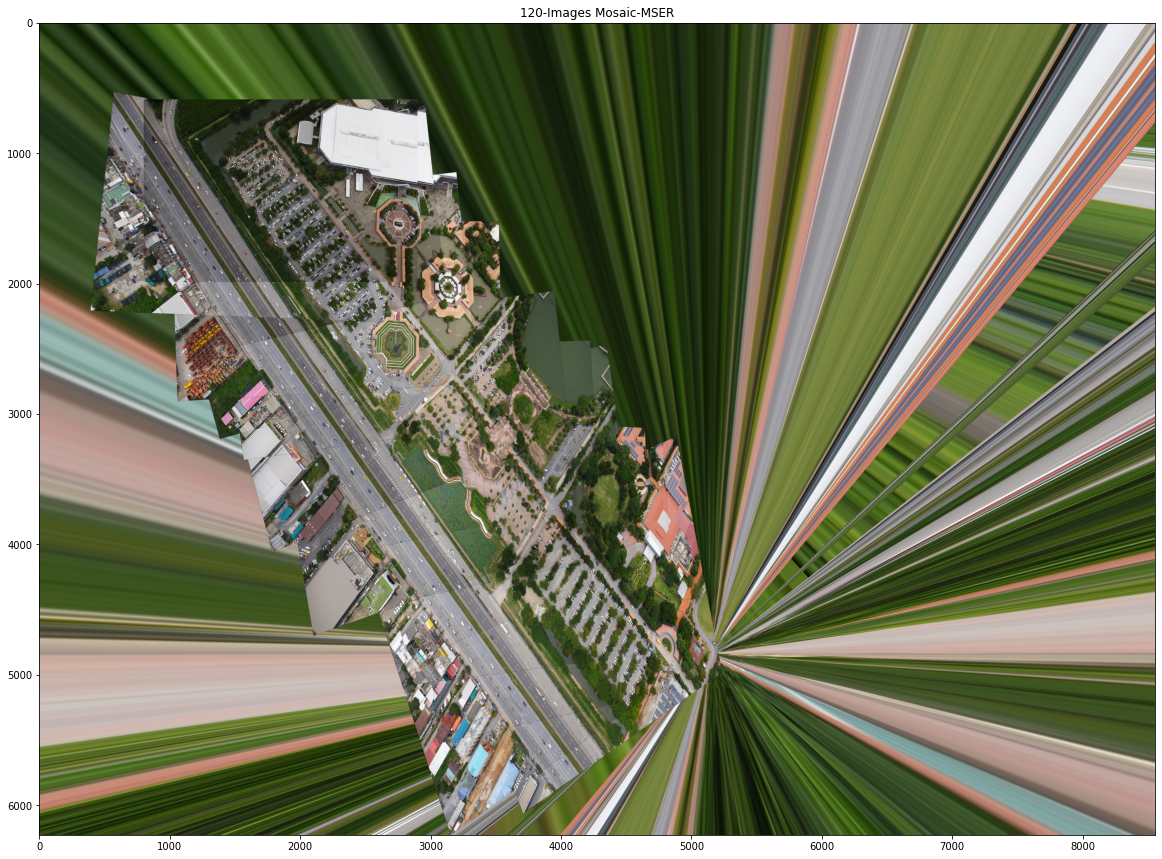

In [35]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_mser , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-MSER')

# For Agast 110 images

In [ ]:
agast = cv2.AgastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]


for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_agast.append(kpt)
    descriptors_all_left_agast.append(descrip)
    points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_agast.append(kpt)
    descriptors_all_right_agast.append(descrip)
    points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

 46%|████▌     | 27/59 [03:41<05:01,  9.41s/it]

In [ ]:
num_kps_agast = []
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast):
  num_kps_agast.append(len(j))

In [ ]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1])
    H_left_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1])
    H_right_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches)    
    

In [ ]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_agast,H_right_agast)

In [ ]:
warp_img = final_steps_left_union(images_left_bgr_no_enhance,H_left_agast,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
warp_imgs_all_agast = final_step_right_union(warp_img,images_right_bgr_no_enhance,H_right_agast,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_agast , cv2.COLOR_BGR2RGB))
ax.set_title('110-Images Mosaic-AGAST')

# For Fast 110 images

In [10]:
fast = cv2.FastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = fast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_fast.append(kpt)
    descriptors_all_left_fast.append(descrip)
    points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = fast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_fast.append(kpt)
    descriptors_all_right_fast.append(descrip)
    points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [06:58<00:00,  7.09s/it]


In [ ]:
num_kps_fast = []
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast):
  num_kps_fast.append(len(j))

In [ ]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1])
    H_left_fast.append(H_a)
    num_matches_fast.append(matches)
    num_good_matches_fast.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1])
    H_right_fast.append(H_a)
    num_matches_fast.append(matches)
    num_good_matches_fast.append(gd_matches) 

In [ ]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_fast,H_right_fast)

In [ ]:
warp_img = final_steps_left_union(images_left_bgr_no_enhance,H_left_fast,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
warp_imgs_all_fast = final_step_right_union(warp_img,images_right_bgr_no_enhance,H_right_fast,omax,omin,umax,umin,T,H,W,HT)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_fast , cv2.COLOR_BGR2RGB))
ax.set_title('110-Images Mosaic-FAST')

# For Gftt 110 images

In [11]:
gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_gftt.append(kpt)
    descriptors_all_left_gftt.append(descrip)
    points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_gftt.append(kpt)
    descriptors_all_right_gftt.append(descrip)
    points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:12<00:00,  4.72it/s]


In [17]:
num_kps_gftt = []
for  j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt):
  num_kps_gftt.append(len(j))


100%|██████████| 110/110 [00:00<00:00, 29827.61it/s]


In [22]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1])
    H_left_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1])
    H_right_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches) 

  6%|▌         | 3/51 [00:00<00:04, 10.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 230



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 106




 10%|▉         | 5/51 [00:00<00:04, 10.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 198



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 254



Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 261




 18%|█▊        | 9/51 [00:00<00:03, 11.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 352
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 381
Number of Robust matches 275



Number of matches 1000
Number of matches After Lowe's Ratio 420
Number of Robust matches 318




 22%|██▏       | 11/51 [00:00<00:03, 11.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 323
Number of Robust matches 224



Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 261




 29%|██▉       | 15/51 [00:01<00:03, 11.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 276



Number of matches 1000
Number of matches After Lowe's Ratio 14
Number of Robust matches 5




 33%|███▎      | 17/51 [00:01<00:02, 11.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 30




 41%|████      | 21/51 [00:01<00:02, 11.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 21



Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 159



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 88




 45%|████▌     | 23/51 [00:02<00:02, 10.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 30
Number of Robust matches 6



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 185




 49%|████▉     | 25/51 [00:02<00:02, 10.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 395
Number of Robust matches 210



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 197



Number of matches 1000
Number of matches After Lowe's Ratio 345
Number of Robust matches 192




 53%|█████▎    | 27/51 [00:02<00:02, 10.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 136



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 142



Number of matches 1000
Number of matches After Lowe's Ratio 267


 61%|██████    | 31/51 [00:02<00:01, 10.77it/s]

Number of Robust matches 141



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 277



Number of matches 1000
Number of matches After Lowe's Ratio 399
Number of Robust matches 324




 65%|██████▍   | 33/51 [00:02<00:01, 10.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 353
Number of Robust matches 294



Number of matches 1000
Number of matches After Lowe's Ratio 441
Number of Robust matches 357



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 294




 73%|███████▎  | 37/51 [00:03<00:01, 11.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 392
Number of Robust matches 301



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 229



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 188




 76%|███████▋  | 39/51 [00:03<00:01, 11.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 176



Number of matches 1000
Number of matches After Lowe's Ratio 490
Number of Robust matches 404



Number of matches 1000
Number of matches After Lowe's Ratio 454
Number of Robust matches 338




 84%|████████▍ | 43/51 [00:03<00:00, 11.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 195



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 369
Number of Robust matches 253




 88%|████████▊ | 45/51 [00:04<00:00, 11.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 187



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 190




 96%|█████████▌| 49/51 [00:04<00:00, 11.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 395
Number of Robust matches 278



Number of matches 1000
Number of matches After Lowe's Ratio 218
Number of Robust matches 105



Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 162




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 24



Number of matches 1000
Number of matches After Lowe's Ratio 208
Number of Robust matches 135




  5%|▌         | 3/59 [00:00<00:06,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 79




  8%|▊         | 5/59 [00:00<00:05,  9.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 106



Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 90



Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 165




 14%|█▎        | 8/59 [00:00<00:05,  9.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 8



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 23




 19%|█▊        | 11/59 [00:01<00:04, 10.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 199
Number of Robust matches 86



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 280




 22%|██▏       | 13/59 [00:01<00:04, 10.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 387
Number of Robust matches 325



Number of matches 1000
Number of matches After Lowe's Ratio 252
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 57




 29%|██▉       | 17/59 [00:01<00:03, 10.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 260



Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 461
Number of Robust matches 426




 32%|███▏      | 19/59 [00:01<00:03, 10.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 451
Number of Robust matches 388



Number of matches 1000
Number of matches After Lowe's Ratio 389
Number of Robust matches 267



Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 265




 39%|███▉      | 23/59 [00:02<00:03, 11.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 225
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 360
Number of Robust matches 265



Number of matches 1000
Number of matches After Lowe's Ratio 377
Number of Robust matches 280




 42%|████▏     | 25/59 [00:02<00:03, 11.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 297



Number of matches 1000
Number of matches After Lowe's Ratio 310
Number of Robust matches 230



Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 255




 49%|████▉     | 29/59 [00:02<00:02, 11.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 221



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 199




 53%|█████▎    | 31/59 [00:02<00:02, 11.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 161



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 137



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 23




 56%|█████▌    | 33/59 [00:03<00:02, 11.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 154
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 5



Number of matches 1000
Number of matches After Lowe's Ratio 133


 63%|██████▎   | 37/59 [00:03<00:01, 11.28it/s]

Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 191




 66%|██████▌   | 39/59 [00:03<00:01, 11.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 138



Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 67




 73%|███████▎  | 43/59 [00:03<00:01, 11.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 389
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 120



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 38




 76%|███████▋  | 45/59 [00:04<00:01, 10.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 194




 83%|████████▎ | 49/59 [00:04<00:00, 11.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 340



Number of matches 1000
Number of matches After Lowe's Ratio 345
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 536
Number of Robust matches 445




 86%|████████▋ | 51/59 [00:04<00:00, 11.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 207



Number of matches 1000
Number of matches After Lowe's Ratio 471
Number of Robust matches 360



Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 138




 93%|█████████▎| 55/59 [00:05<00:00, 10.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 250



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 238



Number of matches 1000
Number of matches After Lowe's Ratio 472
Number of Robust matches 347




 97%|█████████▋| 57/59 [00:05<00:00, 10.65it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 446
Number of Robust matches 363



Number of matches 1000
Number of matches After Lowe's Ratio 401
Number of Robust matches 316




In [24]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_gftt,H_right_gftt)

Step1:Done
Step2:Done


In [25]:
warp_img = final_steps_left_union(images_left_bgr_no_enhance,H_left_gftt,omax,omin,umax,umin,T,H,W,HT)

step31:Done


In [26]:
warp_imgs_all_gftt = final_step_right_union(warp_img,images_right_bgr_no_enhance,H_right_gftt,omax,omin,umax,umin,T,H,W,HT)

step32:Done


Text(0.5, 1.0, ' Mosaic using Gftt Image')

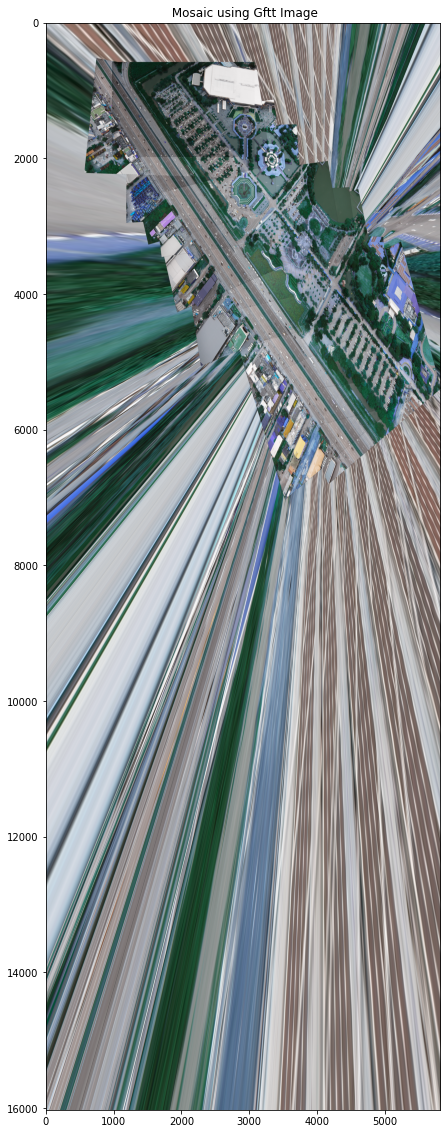

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(warp_imgs_all_gftt)
plt.title(' Mosaic using Gftt Image')


# For Kaze 110 images

In [14]:
kaze = cv2.KAZE_create()
keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for imgs in tqdm(images_left_bgr):
    kpt = kaze.detect(imgs,None)
    kpt,descrip = kaze.compute(imgs, kpt)
    keypoints_all_left_kaze.append(kpt)
    descriptors_all_left_kaze.append(descrip)
    points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = kaze.detect(imgs,None)
    kpt,descrip = kaze.compute(imgs, kpt)
    keypoints_all_right_kaze.append(kpt)
    descriptors_all_right_kaze.append(descrip)
    points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [06:59<00:00,  7.10s/it]


In [20]:
num_kps_kaze = []
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze):
  num_kps_kaze.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 397735.72it/s]


In [24]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
    H_left_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
    H_right_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)    
    

  2%|▏         | 1/51 [00:01<01:12,  1.46s/it]


Number of matches 22285
Number of matches After Lowe's Ratio 5336
Number of Robust matches 3611




  4%|▍         | 2/51 [00:03<01:16,  1.55s/it]


Number of matches 22018
Number of matches After Lowe's Ratio 6512
Number of Robust matches 4800




  6%|▌         | 3/51 [00:05<01:20,  1.67s/it]


Number of matches 24330
Number of matches After Lowe's Ratio 6243
Number of Robust matches 4128




  8%|▊         | 4/51 [00:07<01:27,  1.86s/it]


Number of matches 24904
Number of matches After Lowe's Ratio 9111
Number of Robust matches 6161




 10%|▉         | 5/51 [00:09<01:30,  1.97s/it]


Number of matches 23410
Number of matches After Lowe's Ratio 6915
Number of Robust matches 5282




 12%|█▏        | 6/51 [00:11<01:32,  2.05s/it]


Number of matches 21871
Number of matches After Lowe's Ratio 7173
Number of Robust matches 5237




 14%|█▎        | 7/51 [00:13<01:29,  2.03s/it]


Number of matches 21387
Number of matches After Lowe's Ratio 6390
Number of Robust matches 5207




 16%|█▌        | 8/51 [00:15<01:22,  1.91s/it]


Number of matches 21095
Number of matches After Lowe's Ratio 7119
Number of Robust matches 5557




 18%|█▊        | 9/51 [00:17<01:17,  1.86s/it]


Number of matches 21423
Number of matches After Lowe's Ratio 8038
Number of Robust matches 5355




 20%|█▉        | 10/51 [00:19<01:15,  1.85s/it]


Number of matches 20665
Number of matches After Lowe's Ratio 6637
Number of Robust matches 4556




 22%|██▏       | 11/51 [00:20<01:10,  1.77s/it]


Number of matches 21776
Number of matches After Lowe's Ratio 5891
Number of Robust matches 3285




 24%|██▎       | 12/51 [00:22<01:11,  1.84s/it]


Number of matches 21075
Number of matches After Lowe's Ratio 5816
Number of Robust matches 4016




 25%|██▌       | 13/51 [00:24<01:10,  1.85s/it]


Number of matches 22361
Number of matches After Lowe's Ratio 5750
Number of Robust matches 3714




 27%|██▋       | 14/51 [00:26<01:09,  1.89s/it]


Number of matches 21739
Number of matches After Lowe's Ratio 4923
Number of Robust matches 3137




 29%|██▉       | 15/51 [00:28<01:10,  1.96s/it]


Number of matches 24424
Number of matches After Lowe's Ratio 4574
Number of Robust matches 2599




 31%|███▏      | 16/51 [00:30<01:10,  2.01s/it]


Number of matches 21469
Number of matches After Lowe's Ratio 4705
Number of Robust matches 2409




 33%|███▎      | 17/51 [00:32<01:07,  1.99s/it]


Number of matches 22552
Number of matches After Lowe's Ratio 4912
Number of Robust matches 2800




 35%|███▌      | 18/51 [00:34<01:05,  1.99s/it]


Number of matches 21879
Number of matches After Lowe's Ratio 4774
Number of Robust matches 1850




 37%|███▋      | 19/51 [00:36<01:04,  2.03s/it]


Number of matches 25013
Number of matches After Lowe's Ratio 3107
Number of Robust matches 1393




 39%|███▉      | 20/51 [00:39<01:04,  2.08s/it]


Number of matches 24466
Number of matches After Lowe's Ratio 4452
Number of Robust matches 1845




 41%|████      | 21/51 [00:41<01:02,  2.07s/it]


Number of matches 24798
Number of matches After Lowe's Ratio 2433
Number of Robust matches 877




 43%|████▎     | 22/51 [00:43<00:59,  2.06s/it]


Number of matches 21670
Number of matches After Lowe's Ratio 1116
Number of Robust matches 326




 45%|████▌     | 23/51 [00:45<00:56,  2.01s/it]


Number of matches 21083
Number of matches After Lowe's Ratio 4284
Number of Robust matches 2115




 47%|████▋     | 24/51 [00:46<00:51,  1.91s/it]


Number of matches 19041
Number of matches After Lowe's Ratio 4717
Number of Robust matches 2715




 49%|████▉     | 25/51 [00:48<00:46,  1.79s/it]


Number of matches 21135
Number of matches After Lowe's Ratio 4231
Number of Robust matches 2503




 51%|█████     | 26/51 [00:50<00:45,  1.83s/it]


Number of matches 25378
Number of matches After Lowe's Ratio 5638
Number of Robust matches 2373




 53%|█████▎    | 27/51 [00:52<00:48,  2.03s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5182
Number of Robust matches 2165




 55%|█████▍    | 28/51 [00:55<00:52,  2.26s/it]


Number of matches 31135
Number of matches After Lowe's Ratio 6999
Number of Robust matches 2624




 57%|█████▋    | 29/51 [00:58<00:54,  2.46s/it]


Number of matches 28082
Number of matches After Lowe's Ratio 6745
Number of Robust matches 3174




 59%|█████▉    | 30/51 [01:00<00:51,  2.46s/it]


Number of matches 24578
Number of matches After Lowe's Ratio 6467
Number of Robust matches 3219




 61%|██████    | 31/51 [01:03<00:47,  2.38s/it]


Number of matches 22760
Number of matches After Lowe's Ratio 6570
Number of Robust matches 4112




 63%|██████▎   | 32/51 [01:04<00:42,  2.24s/it]


Number of matches 21201
Number of matches After Lowe's Ratio 6219
Number of Robust matches 3810




 65%|██████▍   | 33/51 [01:06<00:37,  2.10s/it]


Number of matches 21619
Number of matches After Lowe's Ratio 7188
Number of Robust matches 5285




 67%|██████▋   | 34/51 [01:08<00:34,  2.02s/it]


Number of matches 23323
Number of matches After Lowe's Ratio 6381
Number of Robust matches 4220




 69%|██████▊   | 35/51 [01:10<00:31,  2.00s/it]


Number of matches 24274
Number of matches After Lowe's Ratio 7486
Number of Robust matches 4201




 71%|███████   | 36/51 [01:12<00:30,  2.00s/it]


Number of matches 23964
Number of matches After Lowe's Ratio 7815
Number of Robust matches 4805




 73%|███████▎  | 37/51 [01:14<00:28,  2.06s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 7500
Number of Robust matches 4172




 75%|███████▍  | 38/51 [01:16<00:26,  2.06s/it]


Number of matches 22006
Number of matches After Lowe's Ratio 4718
Number of Robust matches 3006




 76%|███████▋  | 39/51 [01:18<00:23,  2.00s/it]


Number of matches 21045
Number of matches After Lowe's Ratio 7925
Number of Robust matches 4860




 78%|███████▊  | 40/51 [01:20<00:21,  1.98s/it]


Number of matches 21574
Number of matches After Lowe's Ratio 7709
Number of Robust matches 5118




 80%|████████  | 41/51 [01:22<00:18,  1.89s/it]


Number of matches 19699
Number of matches After Lowe's Ratio 4771
Number of Robust matches 3305




 82%|████████▏ | 42/51 [01:23<00:16,  1.80s/it]


Number of matches 20924
Number of matches After Lowe's Ratio 4994
Number of Robust matches 3275




 84%|████████▍ | 43/51 [01:25<00:14,  1.80s/it]


Number of matches 21133
Number of matches After Lowe's Ratio 6833
Number of Robust matches 5120




 86%|████████▋ | 44/51 [01:27<00:12,  1.77s/it]


Number of matches 21286
Number of matches After Lowe's Ratio 4964
Number of Robust matches 3532




 88%|████████▊ | 45/51 [01:29<00:10,  1.75s/it]


Number of matches 20795
Number of matches After Lowe's Ratio 5592
Number of Robust matches 3791




 90%|█████████ | 46/51 [01:30<00:08,  1.72s/it]


Number of matches 20754
Number of matches After Lowe's Ratio 4818
Number of Robust matches 2421




 92%|█████████▏| 47/51 [01:32<00:06,  1.73s/it]


Number of matches 21466
Number of matches After Lowe's Ratio 6504
Number of Robust matches 3389




 94%|█████████▍| 48/51 [01:34<00:05,  1.72s/it]


Number of matches 22210
Number of matches After Lowe's Ratio 4469
Number of Robust matches 1819




 96%|█████████▌| 49/51 [01:35<00:03,  1.76s/it]


Number of matches 22050
Number of matches After Lowe's Ratio 5961
Number of Robust matches 2523




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 19110
Number of matches After Lowe's Ratio 1838
Number of Robust matches 542




  2%|▏         | 1/59 [00:01<01:50,  1.91s/it]


Number of matches 17408
Number of matches After Lowe's Ratio 4560
Number of Robust matches 2532




  3%|▎         | 2/59 [00:03<01:40,  1.77s/it]


Number of matches 22778
Number of matches After Lowe's Ratio 3209
Number of Robust matches 1821




  5%|▌         | 3/59 [00:05<01:41,  1.81s/it]


Number of matches 20426
Number of matches After Lowe's Ratio 5970
Number of Robust matches 3397




  7%|▋         | 4/59 [00:06<01:38,  1.79s/it]


Number of matches 20021
Number of matches After Lowe's Ratio 5255
Number of Robust matches 2909




  8%|▊         | 5/59 [00:08<01:33,  1.73s/it]


Number of matches 19469
Number of matches After Lowe's Ratio 5546
Number of Robust matches 3050




 10%|█         | 6/59 [00:10<01:29,  1.69s/it]


Number of matches 20398
Number of matches After Lowe's Ratio 5001
Number of Robust matches 2573




 12%|█▏        | 7/59 [00:11<01:28,  1.70s/it]


Number of matches 23066
Number of matches After Lowe's Ratio 681
Number of Robust matches 173




 14%|█▎        | 8/59 [00:13<01:30,  1.77s/it]


Number of matches 17737
Number of matches After Lowe's Ratio 1983
Number of Robust matches 763




 15%|█▌        | 9/59 [00:15<01:22,  1.65s/it]


Number of matches 17684
Number of matches After Lowe's Ratio 2262
Number of Robust matches 999




 17%|█▋        | 10/59 [00:16<01:17,  1.57s/it]


Number of matches 19340
Number of matches After Lowe's Ratio 2961
Number of Robust matches 1471




 19%|█▊        | 11/59 [00:18<01:15,  1.58s/it]


Number of matches 22253
Number of matches After Lowe's Ratio 5347
Number of Robust matches 3694




 20%|██        | 12/59 [00:20<01:18,  1.66s/it]


Number of matches 19990
Number of matches After Lowe's Ratio 5607
Number of Robust matches 3788




 22%|██▏       | 13/59 [00:21<01:14,  1.61s/it]


Number of matches 17969
Number of matches After Lowe's Ratio 2771
Number of Robust matches 1697




 24%|██▎       | 14/59 [00:22<01:09,  1.55s/it]


Number of matches 21377
Number of matches After Lowe's Ratio 1791
Number of Robust matches 1019




 25%|██▌       | 15/59 [00:24<01:09,  1.57s/it]


Number of matches 18219
Number of matches After Lowe's Ratio 4653
Number of Robust matches 3357




 27%|██▋       | 16/59 [00:26<01:07,  1.57s/it]


Number of matches 23113
Number of matches After Lowe's Ratio 3603
Number of Robust matches 2585




 29%|██▉       | 17/59 [00:28<01:09,  1.65s/it]


Number of matches 23306
Number of matches After Lowe's Ratio 8479
Number of Robust matches 5727




 31%|███       | 18/59 [00:29<01:10,  1.73s/it]


Number of matches 22231
Number of matches After Lowe's Ratio 8812
Number of Robust matches 7452




 32%|███▏      | 19/59 [00:31<01:12,  1.81s/it]


Number of matches 20707
Number of matches After Lowe's Ratio 6875
Number of Robust matches 5249




 34%|███▍      | 20/59 [00:33<01:09,  1.79s/it]


Number of matches 21002
Number of matches After Lowe's Ratio 7024
Number of Robust matches 5844




 36%|███▌      | 21/59 [00:35<01:08,  1.81s/it]


Number of matches 22557
Number of matches After Lowe's Ratio 5656
Number of Robust matches 3641




 37%|███▋      | 22/59 [00:37<01:09,  1.88s/it]


Number of matches 22744
Number of matches After Lowe's Ratio 6967
Number of Robust matches 4581




 39%|███▉      | 23/59 [00:39<01:09,  1.93s/it]


Number of matches 23731
Number of matches After Lowe's Ratio 6293
Number of Robust matches 4175




 41%|████      | 24/59 [00:41<01:10,  2.02s/it]


Number of matches 25368
Number of matches After Lowe's Ratio 7109
Number of Robust matches 4203




 42%|████▏     | 25/59 [00:44<01:11,  2.10s/it]


Number of matches 25661
Number of matches After Lowe's Ratio 7457
Number of Robust matches 3628




 44%|████▍     | 26/59 [00:46<01:11,  2.17s/it]


Number of matches 24425
Number of matches After Lowe's Ratio 7855
Number of Robust matches 3642




 46%|████▌     | 27/59 [00:48<01:10,  2.19s/it]


Number of matches 22841
Number of matches After Lowe's Ratio 6343
Number of Robust matches 2558




 47%|████▋     | 28/59 [00:50<01:05,  2.13s/it]


Number of matches 22352
Number of matches After Lowe's Ratio 7262
Number of Robust matches 3080




 49%|████▉     | 29/59 [00:52<01:02,  2.07s/it]


Number of matches 21771
Number of matches After Lowe's Ratio 5814
Number of Robust matches 2302




 51%|█████     | 30/59 [00:54<00:59,  2.04s/it]


Number of matches 20959
Number of matches After Lowe's Ratio 5551
Number of Robust matches 2183




 53%|█████▎    | 31/59 [00:56<00:54,  1.95s/it]


Number of matches 20882
Number of matches After Lowe's Ratio 4413
Number of Robust matches 2286




 54%|█████▍    | 32/59 [00:58<00:53,  1.97s/it]


Number of matches 28555
Number of matches After Lowe's Ratio 2064
Number of Robust matches 909




 56%|█████▌    | 33/59 [01:00<00:56,  2.16s/it]


Number of matches 26455
Number of matches After Lowe's Ratio 4181
Number of Robust matches 1630




 58%|█████▊    | 34/59 [01:03<00:57,  2.31s/it]


Number of matches 31041
Number of matches After Lowe's Ratio 523
Number of Robust matches 49




 59%|█████▉    | 35/59 [01:06<00:58,  2.45s/it]


Number of matches 25532
Number of matches After Lowe's Ratio 3374
Number of Robust matches 1281




 61%|██████    | 36/59 [01:08<00:54,  2.36s/it]


Number of matches 23237
Number of matches After Lowe's Ratio 5682
Number of Robust matches 2426




 63%|██████▎   | 37/59 [01:10<00:49,  2.26s/it]


Number of matches 21219
Number of matches After Lowe's Ratio 4896
Number of Robust matches 2136




 64%|██████▍   | 38/59 [01:12<00:44,  2.10s/it]


Number of matches 20480
Number of matches After Lowe's Ratio 4407
Number of Robust matches 1990




 66%|██████▌   | 39/59 [01:13<00:39,  1.97s/it]


Number of matches 22293
Number of matches After Lowe's Ratio 4745
Number of Robust matches 1757




 68%|██████▊   | 40/59 [01:15<00:36,  1.94s/it]


Number of matches 21755
Number of matches After Lowe's Ratio 4650
Number of Robust matches 1760




 69%|██████▉   | 41/59 [01:17<00:33,  1.88s/it]


Number of matches 22020
Number of matches After Lowe's Ratio 7625
Number of Robust matches 3012




 71%|███████   | 42/59 [01:19<00:32,  1.89s/it]


Number of matches 23245
Number of matches After Lowe's Ratio 4255
Number of Robust matches 1991




 73%|███████▎  | 43/59 [01:21<00:31,  1.96s/it]


Number of matches 22554
Number of matches After Lowe's Ratio 7193
Number of Robust matches 4267




 75%|███████▍  | 44/59 [01:23<00:28,  1.93s/it]


Number of matches 21359
Number of matches After Lowe's Ratio 5425
Number of Robust matches 2457




 76%|███████▋  | 45/59 [01:25<00:26,  1.87s/it]


Number of matches 20079
Number of matches After Lowe's Ratio 4546
Number of Robust matches 2397




 78%|███████▊  | 46/59 [01:26<00:23,  1.80s/it]


Number of matches 20334
Number of matches After Lowe's Ratio 3744
Number of Robust matches 2455




 80%|███████▉  | 47/59 [01:28<00:21,  1.78s/it]


Number of matches 20129
Number of matches After Lowe's Ratio 4645
Number of Robust matches 3002




 81%|████████▏ | 48/59 [01:30<00:19,  1.74s/it]


Number of matches 19798
Number of matches After Lowe's Ratio 4583
Number of Robust matches 2789




 83%|████████▎ | 49/59 [01:31<00:17,  1.71s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 6929
Number of Robust matches 5222




 85%|████████▍ | 50/59 [01:33<00:15,  1.72s/it]


Number of matches 20830
Number of matches After Lowe's Ratio 4534
Number of Robust matches 2895




 86%|████████▋ | 51/59 [01:35<00:13,  1.74s/it]


Number of matches 20716
Number of matches After Lowe's Ratio 7899
Number of Robust matches 5354




 88%|████████▊ | 52/59 [01:36<00:11,  1.68s/it]


Number of matches 13601
Number of matches After Lowe's Ratio 2378
Number of Robust matches 1539




 90%|████████▉ | 53/59 [01:37<00:08,  1.43s/it]


Number of matches 11003
Number of matches After Lowe's Ratio 2964
Number of Robust matches 1572




 92%|█████████▏| 54/59 [01:38<00:06,  1.20s/it]


Number of matches 11226
Number of matches After Lowe's Ratio 1721
Number of Robust matches 867




 93%|█████████▎| 55/59 [01:39<00:04,  1.06s/it]


Number of matches 12178
Number of matches After Lowe's Ratio 3768
Number of Robust matches 2395




 95%|█████████▍| 56/59 [01:40<00:03,  1.02s/it]


Number of matches 17658
Number of matches After Lowe's Ratio 3017
Number of Robust matches 2018




 97%|█████████▋| 57/59 [01:41<00:02,  1.15s/it]


Number of matches 20009
Number of matches After Lowe's Ratio 5649
Number of Robust matches 3697




 98%|█████████▊| 58/59 [01:43<00:01,  1.28s/it]


Number of matches 20037
Number of matches After Lowe's Ratio 5298
Number of Robust matches 3148




In [27]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_kaze,H_right_kaze)


Step1:Done
Step2:Done


In [29]:
warp_img_kaze = final_steps_left_union(images_left_bgr_no_enhance,H_left_kaze,omax,omin,umax,umin,T,H,W,HT)

error: ignored

In [30]:
warp_imgs_all_kaze = final_step_right_union(warp_img_kaze,images_right_bgr_no_enhance,H_right_kaze,omax,omin,umax,umin,T,H,W,HT)

NameError: ignored

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_kaze , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-KAZE')

# For SuperPoint 110 images

In [16]:

keypoint_all_left_superpoint = []
descriptor_all_left_superpoint = []
point_all_left_superpoint = []

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint = []

for ifpth in tqdm(images_left):
    heatmap1, coarse_desc1 = fe.run(ifpth)
    pts_1, desc_1 = fe.key_pt_sampling(ifpth,heatmap1,coarse_desc1,2000)
    
    keypoint_all_left_superpoint.append(to_kpts(pts_1.T))
    descriptor_all_left_superpoint.append(desc_1.T)
    point_all_left_superpoint.append(pts_1.T)
    
    
   

    
for rfpth in tqdm(images_right):
    heatmap1, coarse_desc1 = fe.run(rfpth)
    pts_1, desc_1 = fe.key_pt_sampling(rfpth,heatmap1,coarse_desc1,2000)
    
    keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
    descriptors_all_right_superpoint.append(desc_1.T)
    points_all_right_superpoint.append(pts_1.T)

  0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Number of pts selected: 54477


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  2%|▏         | 1/51 [00:00<00:28,  1.77it/s]

Number of pts selected: 64559


  4%|▍         | 2/51 [00:00<00:25,  1.91it/s]

Number of pts selected: 62731


  6%|▌         | 3/51 [00:01<00:23,  2.04it/s]

Number of pts selected: 66915


  8%|▊         | 4/51 [00:01<00:22,  2.11it/s]

Number of pts selected: 65977


 10%|▉         | 5/51 [00:02<00:20,  2.20it/s]

Number of pts selected: 62256


 12%|█▏        | 6/51 [00:02<00:19,  2.29it/s]

Number of pts selected: 58442


 14%|█▎        | 7/51 [00:03<00:18,  2.38it/s]

Number of pts selected: 52856


 16%|█▌        | 8/51 [00:03<00:17,  2.45it/s]

Number of pts selected: 53728


 18%|█▊        | 9/51 [00:03<00:16,  2.54it/s]

Number of pts selected: 52870


 22%|██▏       | 11/51 [00:04<00:15,  2.64it/s]

Number of pts selected: 48261
Number of pts selected: 53550


 24%|██▎       | 12/51 [00:04<00:14,  2.66it/s]

Number of pts selected: 53339


 25%|██▌       | 13/51 [00:05<00:14,  2.68it/s]

Number of pts selected: 55541


 27%|██▋       | 14/51 [00:05<00:13,  2.67it/s]

Number of pts selected: 53723


 29%|██▉       | 15/51 [00:05<00:13,  2.69it/s]

Number of pts selected: 63642


 31%|███▏      | 16/51 [00:06<00:13,  2.62it/s]

Number of pts selected: 63850


 33%|███▎      | 17/51 [00:06<00:13,  2.58it/s]

Number of pts selected: 63381


 35%|███▌      | 18/51 [00:07<00:12,  2.55it/s]

Number of pts selected: 57585


 39%|███▉      | 20/51 [00:07<00:11,  2.68it/s]

Number of pts selected: 45310


 41%|████      | 21/51 [00:08<00:10,  2.77it/s]

Number of pts selected: 43137


 43%|████▎     | 22/51 [00:08<00:09,  2.90it/s]

Number of pts selected: 32917


 45%|████▌     | 23/51 [00:08<00:09,  2.98it/s]

Number of pts selected: 36228


 47%|████▋     | 24/51 [00:09<00:08,  3.05it/s]

Number of pts selected: 36082


 49%|████▉     | 25/51 [00:09<00:08,  3.10it/s]

Number of pts selected: 35452


 51%|█████     | 26/51 [00:09<00:08,  3.09it/s]

Number of pts selected: 41594


 53%|█████▎    | 27/51 [00:10<00:07,  3.09it/s]

Number of pts selected: 41845
Number of pts selected: 52565


 55%|█████▍    | 28/51 [00:10<00:07,  2.97it/s]

Number of pts selected: 51583


 57%|█████▋    | 29/51 [00:10<00:07,  2.92it/s]

Number of pts selected: 53864


 59%|█████▉    | 30/51 [00:11<00:07,  2.85it/s]

Number of pts selected: 51580


 61%|██████    | 31/51 [00:11<00:07,  2.81it/s]

Number of pts selected: 52497


 63%|██████▎   | 32/51 [00:11<00:06,  2.76it/s]

Number of pts selected: 53351


 65%|██████▍   | 33/51 [00:12<00:06,  2.75it/s]

Number of pts selected: 58937


 67%|██████▋   | 34/51 [00:12<00:06,  2.66it/s]

Number of pts selected: 63670


 69%|██████▊   | 35/51 [00:13<00:06,  2.61it/s]

Number of pts selected: 63164


 71%|███████   | 36/51 [00:13<00:05,  2.57it/s]

Number of pts selected: 61341


 73%|███████▎  | 37/51 [00:13<00:05,  2.55it/s]

Number of pts selected: 62577


 75%|███████▍  | 38/51 [00:14<00:05,  2.55it/s]

Number of pts selected: 60963


 76%|███████▋  | 39/51 [00:14<00:04,  2.54it/s]

Number of pts selected: 59765


 78%|███████▊  | 40/51 [00:15<00:04,  2.53it/s]

Number of pts selected: 59418


 80%|████████  | 41/51 [00:15<00:03,  2.53it/s]

Number of pts selected: 57060


 82%|████████▏ | 42/51 [00:15<00:03,  2.55it/s]

Number of pts selected: 60042


 84%|████████▍ | 43/51 [00:16<00:03,  2.56it/s]

Number of pts selected: 60481


 86%|████████▋ | 44/51 [00:16<00:02,  2.55it/s]

Number of pts selected: 61320


 88%|████████▊ | 45/51 [00:17<00:02,  2.55it/s]

Number of pts selected: 60847


 90%|█████████ | 46/51 [00:17<00:01,  2.56it/s]

Number of pts selected: 57839


 92%|█████████▏| 47/51 [00:17<00:01,  2.56it/s]

Number of pts selected: 59702


 94%|█████████▍| 48/51 [00:18<00:01,  2.57it/s]

Number of pts selected: 58094


 96%|█████████▌| 49/51 [00:18<00:00,  2.57it/s]

Number of pts selected: 59875


 98%|█████████▊| 50/51 [00:19<00:00,  2.58it/s]

Number of pts selected: 57318


  0%|          | 0/59 [00:00<?, ?it/s]

Number of pts selected: 56486


  3%|▎         | 2/59 [00:00<00:20,  2.72it/s]

Number of pts selected: 43863


  5%|▌         | 3/59 [00:01<00:20,  2.75it/s]

Number of pts selected: 50000


  7%|▋         | 4/59 [00:01<00:19,  2.82it/s]

Number of pts selected: 43516


  8%|▊         | 5/59 [00:01<00:18,  2.89it/s]

Number of pts selected: 41297


 10%|█         | 6/59 [00:02<00:18,  2.93it/s]

Number of pts selected: 42597


 12%|█▏        | 7/59 [00:02<00:17,  2.92it/s]

Number of pts selected: 44806


 14%|█▎        | 8/59 [00:02<00:17,  2.94it/s]

Number of pts selected: 43315


 15%|█▌        | 9/59 [00:03<00:16,  2.98it/s]

Number of pts selected: 39997


 17%|█▋        | 10/59 [00:03<00:16,  3.04it/s]

Number of pts selected: 37697


 19%|█▊        | 11/59 [00:03<00:15,  3.01it/s]

Number of pts selected: 41027


 20%|██        | 12/59 [00:04<00:15,  3.00it/s]

Number of pts selected: 45908


 22%|██▏       | 13/59 [00:04<00:15,  2.94it/s]

Number of pts selected: 49188
Number of pts selected: 57475


 24%|██▎       | 14/59 [00:04<00:15,  2.84it/s]

Number of pts selected: 55483


 25%|██▌       | 15/59 [00:05<00:15,  2.79it/s]

Number of pts selected: 52557


 27%|██▋       | 16/59 [00:05<00:15,  2.76it/s]

Number of pts selected: 55422


 29%|██▉       | 17/59 [00:05<00:15,  2.72it/s]

Number of pts selected: 54316


 32%|███▏      | 19/59 [00:06<00:14,  2.72it/s]

Number of pts selected: 51662


 34%|███▍      | 20/59 [00:07<00:14,  2.75it/s]

Number of pts selected: 50162


 36%|███▌      | 21/59 [00:07<00:13,  2.77it/s]

Number of pts selected: 48664


 37%|███▋      | 22/59 [00:07<00:13,  2.82it/s]

Number of pts selected: 46023


 39%|███▉      | 23/59 [00:08<00:12,  2.83it/s]

Number of pts selected: 48049
Number of pts selected: 57650


 41%|████      | 24/59 [00:08<00:12,  2.77it/s]

Number of pts selected: 70799


 42%|████▏     | 25/59 [00:08<00:12,  2.63it/s]

Number of pts selected: 72440


 44%|████▍     | 26/59 [00:09<00:13,  2.51it/s]

Number of pts selected: 75195


 46%|████▌     | 27/59 [00:09<00:13,  2.43it/s]

Number of pts selected: 72197


 47%|████▋     | 28/59 [00:10<00:12,  2.41it/s]

Number of pts selected: 66163


 49%|████▉     | 29/59 [00:10<00:12,  2.39it/s]

Number of pts selected: 59430


 51%|█████     | 30/59 [00:10<00:11,  2.45it/s]

Number of pts selected: 61074


 53%|█████▎    | 31/59 [00:11<00:11,  2.43it/s]

Number of pts selected: 50121


 56%|█████▌    | 33/59 [00:12<00:09,  2.66it/s]

Number of pts selected: 33851


 58%|█████▊    | 34/59 [00:12<00:08,  2.80it/s]

Number of pts selected: 32768


 59%|█████▉    | 35/59 [00:12<00:08,  2.89it/s]

Number of pts selected: 36270
Number of pts selected: 50163


 61%|██████    | 36/59 [00:13<00:08,  2.84it/s]

Number of pts selected: 47558


 63%|██████▎   | 37/59 [00:13<00:07,  2.80it/s]

Number of pts selected: 54703


 64%|██████▍   | 38/59 [00:13<00:07,  2.76it/s]

Number of pts selected: 60403


 66%|██████▌   | 39/59 [00:14<00:07,  2.66it/s]

Number of pts selected: 73839


 68%|██████▊   | 40/59 [00:14<00:07,  2.53it/s]

Number of pts selected: 72110


 69%|██████▉   | 41/59 [00:15<00:07,  2.45it/s]

Number of pts selected: 70240


 71%|███████   | 42/59 [00:15<00:07,  2.41it/s]

Number of pts selected: 65699


 73%|███████▎  | 43/59 [00:15<00:06,  2.42it/s]

Number of pts selected: 63686


 75%|███████▍  | 44/59 [00:16<00:06,  2.43it/s]

Number of pts selected: 57061


 78%|███████▊  | 46/59 [00:17<00:04,  2.61it/s]

Number of pts selected: 44654


 80%|███████▉  | 47/59 [00:17<00:04,  2.71it/s]

Number of pts selected: 42427


 81%|████████▏ | 48/59 [00:17<00:03,  2.75it/s]

Number of pts selected: 41848


 83%|████████▎ | 49/59 [00:18<00:03,  2.80it/s]

Number of pts selected: 43600


 85%|████████▍ | 50/59 [00:18<00:03,  2.84it/s]

Number of pts selected: 42041


 86%|████████▋ | 51/59 [00:18<00:02,  2.87it/s]

Number of pts selected: 44061


 88%|████████▊ | 52/59 [00:19<00:02,  2.90it/s]

Number of pts selected: 44166


 90%|████████▉ | 53/59 [00:19<00:02,  2.87it/s]

Number of pts selected: 46081


 92%|█████████▏| 54/59 [00:19<00:01,  2.90it/s]

Number of pts selected: 41958


 93%|█████████▎| 55/59 [00:20<00:01,  2.94it/s]

Number of pts selected: 41057


 95%|█████████▍| 56/59 [00:20<00:01,  2.92it/s]

Number of pts selected: 41750


 97%|█████████▋| 57/59 [00:20<00:00,  2.94it/s]

Number of pts selected: 43361


 98%|█████████▊| 58/59 [00:21<00:00,  2.94it/s]

Number of pts selected: 45194


100%|██████████| 59/59 [00:21<00:00,  2.89it/s]

Number of pts selected: 46811


100%|██████████| 59/59 [00:21<00:00,  2.74it/s]


In [17]:
num_kps_superpoint = []
for j in tqdm(keypoint_all_left_superpoint + keypoints_all_right_superpoint):
  num_kps_superpoint.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 48905.39it/s]


In [21]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoint_all_left_superpoint[j:j+2][::-1],point_all_left_superpoint[j:j+2][::-1],descriptor_all_left_superpoint[j:j+2][::-1])
    H_left_superpoint.append(H_a)
    num_matches_superpoint.append(matches)
    num_good_matches_superpoint.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1])
    H_right_superpoint.append(H_a)
    num_matches_superpoint.append(matches)
    num_good_matches_superpoint.append(gd_matches) 

  2%|▏         | 1/51 [00:00<00:22,  2.27it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 279
Number of Robust matches 57




  4%|▍         | 2/51 [00:00<00:21,  2.30it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 119
Number of Robust matches 36




  6%|▌         | 3/51 [00:01<00:21,  2.27it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 126
Number of Robust matches 33




  8%|▊         | 4/51 [00:01<00:20,  2.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 223
Number of Robust matches 58




 10%|▉         | 5/51 [00:02<00:20,  2.29it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 213
Number of Robust matches 53




 12%|█▏        | 6/51 [00:02<00:19,  2.29it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 129
Number of Robust matches 36




 14%|█▎        | 7/51 [00:03<00:19,  2.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 231
Number of Robust matches 46




 16%|█▌        | 8/51 [00:03<00:19,  2.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 256
Number of Robust matches 59




 18%|█▊        | 9/51 [00:04<00:19,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 322
Number of Robust matches 68




 20%|█▉        | 10/51 [00:04<00:18,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 221
Number of Robust matches 51




 22%|██▏       | 11/51 [00:04<00:18,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 200
Number of Robust matches 49




 24%|██▎       | 12/51 [00:05<00:17,  2.17it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 238
Number of Robust matches 42




 25%|██▌       | 13/51 [00:05<00:17,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 116
Number of Robust matches 24




 27%|██▋       | 14/51 [00:06<00:16,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 167
Number of Robust matches 30




 29%|██▉       | 15/51 [00:06<00:16,  2.24it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 58
Number of Robust matches 17




 31%|███▏      | 16/51 [00:07<00:15,  2.28it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 69
Number of Robust matches 21




 33%|███▎      | 17/51 [00:07<00:15,  2.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 208
Number of Robust matches 47




 35%|███▌      | 18/51 [00:08<00:15,  2.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 84
Number of Robust matches 19




 37%|███▋      | 19/51 [00:08<00:14,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 46
Number of Robust matches 7




 39%|███▉      | 20/51 [00:09<00:14,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 154
Number of Robust matches 23




 41%|████      | 21/51 [00:09<00:13,  2.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 94
Number of Robust matches 23




 43%|████▎     | 22/51 [00:09<00:13,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4




 45%|████▌     | 23/51 [00:10<00:12,  2.27it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 239
Number of Robust matches 37




 47%|████▋     | 24/51 [00:10<00:12,  2.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 248
Number of Robust matches 38




 49%|████▉     | 25/51 [00:11<00:11,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 186
Number of Robust matches 30




 51%|█████     | 26/51 [00:11<00:11,  2.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 253
Number of Robust matches 49




 53%|█████▎    | 27/51 [00:12<00:11,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 199
Number of Robust matches 26




 55%|█████▍    | 28/51 [00:12<00:10,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 232
Number of Robust matches 29




 57%|█████▋    | 29/51 [00:13<00:09,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 152
Number of Robust matches 27




 59%|█████▉    | 30/51 [00:13<00:09,  2.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 213
Number of Robust matches 34




 61%|██████    | 31/51 [00:13<00:08,  2.24it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 230
Number of Robust matches 45




 63%|██████▎   | 32/51 [00:14<00:08,  2.30it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 229
Number of Robust matches 60




 65%|██████▍   | 33/51 [00:14<00:07,  2.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 289
Number of Robust matches 69




 67%|██████▋   | 34/51 [00:15<00:07,  2.31it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 168
Number of Robust matches 30




 69%|██████▊   | 35/51 [00:15<00:07,  2.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 36




 71%|███████   | 36/51 [00:16<00:06,  2.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 212
Number of Robust matches 51




 73%|███████▎  | 37/51 [00:16<00:06,  2.23it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 190
Number of Robust matches 43




 75%|███████▍  | 38/51 [00:17<00:05,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 128
Number of Robust matches 25




 76%|███████▋  | 39/51 [00:17<00:05,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 367
Number of Robust matches 71




 78%|███████▊  | 40/51 [00:17<00:05,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 309
Number of Robust matches 55




 80%|████████  | 41/51 [00:18<00:04,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 37




 82%|████████▏ | 42/51 [00:18<00:04,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 180
Number of Robust matches 39




 84%|████████▍ | 43/51 [00:19<00:03,  2.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 222
Number of Robust matches 47




 86%|████████▋ | 44/51 [00:19<00:03,  2.13it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 98
Number of Robust matches 24




 88%|████████▊ | 45/51 [00:20<00:02,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 156
Number of Robust matches 39




 90%|█████████ | 46/51 [00:20<00:02,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 150
Number of Robust matches 30




 92%|█████████▏| 47/51 [00:21<00:01,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 243
Number of Robust matches 59




 94%|█████████▍| 48/51 [00:21<00:01,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 83
Number of Robust matches 13




 96%|█████████▌| 49/51 [00:22<00:00,  2.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 29




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 32
Number of Robust matches 7




  2%|▏         | 1/59 [00:00<00:27,  2.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 80
Number of Robust matches 15




  3%|▎         | 2/59 [00:00<00:27,  2.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 90
Number of Robust matches 19




  5%|▌         | 3/59 [00:01<00:26,  2.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 142
Number of Robust matches 33




  7%|▋         | 4/59 [00:01<00:26,  2.11it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 232
Number of Robust matches 46




  8%|▊         | 5/59 [00:02<00:26,  2.07it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 139
Number of Robust matches 31




 10%|█         | 6/59 [00:02<00:25,  2.05it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 42




 12%|█▏        | 7/59 [00:03<00:24,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 14
Number of Robust matches 4




 14%|█▎        | 8/59 [00:03<00:24,  2.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 59
Number of Robust matches 12




 15%|█▌        | 9/59 [00:04<00:23,  2.11it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 48
Number of Robust matches 11




 17%|█▋        | 10/59 [00:04<00:23,  2.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 212
Number of Robust matches 39




 19%|█▊        | 11/59 [00:05<00:22,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 282
Number of Robust matches 72




 20%|██        | 12/59 [00:05<00:21,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 332
Number of Robust matches 77




 22%|██▏       | 13/59 [00:06<00:21,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 118
Number of Robust matches 23




 24%|██▎       | 14/59 [00:06<00:20,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 25
Number of Robust matches 7




 25%|██▌       | 15/59 [00:07<00:20,  2.17it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 216
Number of Robust matches 63




 27%|██▋       | 16/59 [00:07<00:19,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 116
Number of Robust matches 27




 29%|██▉       | 17/59 [00:08<00:19,  2.13it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 384
Number of Robust matches 87




 31%|███       | 18/59 [00:08<00:19,  2.12it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 256
Number of Robust matches 60




 32%|███▏      | 19/59 [00:08<00:18,  2.12it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 229
Number of Robust matches 55




 34%|███▍      | 20/59 [00:09<00:18,  2.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 296
Number of Robust matches 73




 36%|███▌      | 21/59 [00:09<00:17,  2.20it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 118
Number of Robust matches 28




 37%|███▋      | 22/59 [00:10<00:17,  2.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 197
Number of Robust matches 43




 39%|███▉      | 23/59 [00:10<00:16,  2.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 206
Number of Robust matches 38




 41%|████      | 24/59 [00:11<00:16,  2.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 35




 42%|████▏     | 25/59 [00:11<00:16,  2.12it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 227
Number of Robust matches 32




 44%|████▍     | 26/59 [00:12<00:15,  2.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 236
Number of Robust matches 33




 46%|████▌     | 27/59 [00:12<00:15,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 197
Number of Robust matches 31




 47%|████▋     | 28/59 [00:13<00:14,  2.09it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 367
Number of Robust matches 48




 49%|████▉     | 29/59 [00:13<00:14,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 283
Number of Robust matches 39




 51%|█████     | 30/59 [00:14<00:13,  2.10it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 187
Number of Robust matches 48




 53%|█████▎    | 31/59 [00:14<00:13,  2.12it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 180
Number of Robust matches 43




 54%|█████▍    | 32/59 [00:15<00:12,  2.17it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 23
Number of Robust matches 6




 56%|█████▌    | 33/59 [00:15<00:12,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 62
Number of Robust matches 14




 58%|█████▊    | 34/59 [00:15<00:11,  2.18it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 11
Number of Robust matches 4




 59%|█████▉    | 35/59 [00:16<00:11,  2.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 105
Number of Robust matches 24




 61%|██████    | 36/59 [00:16<00:10,  2.16it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 323
Number of Robust matches 43




 63%|██████▎   | 37/59 [00:17<00:10,  2.02it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 250
Number of Robust matches 28




 64%|██████▍   | 38/59 [00:17<00:10,  2.07it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 181
Number of Robust matches 28




 66%|██████▌   | 39/59 [00:18<00:09,  2.03it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 200
Number of Robust matches 35




 68%|██████▊   | 40/59 [00:18<00:09,  2.05it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 130
Number of Robust matches 17




 69%|██████▉   | 41/59 [00:19<00:08,  2.06it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 338
Number of Robust matches 50




 71%|███████   | 42/59 [00:19<00:08,  2.08it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 130
Number of Robust matches 25




 73%|███████▎  | 43/59 [00:20<00:07,  2.11it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 148
Number of Robust matches 38




 75%|███████▍  | 44/59 [00:20<00:07,  2.13it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 267
Number of Robust matches 57




 76%|███████▋  | 45/59 [00:21<00:06,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 136
Number of Robust matches 30




 78%|███████▊  | 46/59 [00:21<00:05,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 68
Number of Robust matches 22




 80%|███████▉  | 47/59 [00:22<00:05,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 290
Number of Robust matches 69




 81%|████████▏ | 48/59 [00:22<00:05,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 179
Number of Robust matches 45




 83%|████████▎ | 49/59 [00:23<00:04,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 515
Number of Robust matches 172




 85%|████████▍ | 50/59 [00:23<00:04,  2.17it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 149
Number of Robust matches 32




 86%|████████▋ | 51/59 [00:23<00:03,  2.14it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 348
Number of Robust matches 80




 88%|████████▊ | 52/59 [00:24<00:03,  2.11it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 56
Number of Robust matches 10




 90%|████████▉ | 53/59 [00:24<00:02,  2.15it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 135
Number of Robust matches 29




 92%|█████████▏| 54/59 [00:25<00:02,  2.25it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 94
Number of Robust matches 30




 93%|█████████▎| 55/59 [00:25<00:01,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 464
Number of Robust matches 110




 95%|█████████▍| 56/59 [00:26<00:01,  2.22it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 186
Number of Robust matches 35




 97%|█████████▋| 57/59 [00:26<00:00,  2.21it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 322
Number of Robust matches 55




 98%|█████████▊| 58/59 [00:27<00:00,  2.19it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 252
Number of Robust matches 49




In [24]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_superpoint,H_right_superpoint)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_mser = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)